In [1]:
using Revise
using GLMakie
using FileIO
using LsqFit
using Statistics
using Colors


pathBase = joinpath(@__DIR__, "../src/")

includet(pathBase * "RLEnvironment.jl")
includet(pathBase * "RLExperiment.jl")
includet(pathBase * "SharedStructs.jl")
includet(pathBase * "Training.jl")
includet(pathBase * "Analysis.jl")
includet(pathBase * "Visualization.jl")
using .SharedStructs
includet(pathBase * "MathFunctions.jl")
using .MathFunctions
using Suppressor: @suppress_err


# Function definitions

In [2]:
FVF(vec) = Vector{Float64}(vec)

function reverse_nesting(nested_dict)
    # Get the subkeys from one of the main keys (assuming all main keys have the same subkeys)
    subkeys = keys(first(nested_dict))
    # Create a new dictionary where subkeys will be the first-level keys
    reversed_dict = Dict(subkey => Dict() for subkey in subkeys)
    # Iterate over the original nested dictionary and reorganize
    for (key, subdict) in nested_dict
        for (subkey, value) in subdict
            reversed_dict[subkey][key] = value
        end
    end
    return reversed_dict
end

function GetRewardTrajectory(d)
    ex = d["ex"]
    hookResults = ex.hook.episodeList
    rewList = []
    for ep in 1:length(hookResults)
        push!(rewList, hookResults[ep].rewards)
    end
    return rewList
end

function GetPlusOrientationTrajectory(d)
    ex = d["ex"]
    orList = []
    hookResults = ex.hook.episodeList
    for ep in 1:length(hookResults)
        epOrs = []
        for t in 1:(length(hookResults[ep].agentHandlerList))
            if length(hookResults[ep].agentHandlerList[t].PlusDefects) == 1
                push!(epOrs, hookResults[ep].agentHandlerList[t].PlusDefects[1].Orientation)
            end
        end
        push!(orList, epOrs)
    end
    return orList
end

function GetBehaviorPolicy(d)
    ex = d["ex"]
    return ex.policy.policy.behavior_actor.model
end

function UnpackArrayList(arrayList)
    array = []
    for n in 1:length(arrayList)
        array = vcat(array, arrayList[n])
    end 
    return array
end

function RepeatList(list, n)
    retList = []
    for t in 1:length(list)
        for k in 1:n
            push!(retList, list[t])
        end 
    end 
    return retList
end

function GetStateArrays(ex, epNum)
    nt = length(ex.hook.stateTrajList[epNum])
    velocityArray = [deepcopy(ex.hook.stateTrajList[epNum][t].velocitySoA) for t in 1:nt]
    nematicArray = [deepcopy(ex.hook.stateTrajList[epNum][t].nematicSoA) for t in 1:nt]
    activityArray = [deepcopy(ex.hook.stateTrajList[epNum][t].activityField) for t in 1:nt]
    agentHandlerArray = [deepcopy(ex.hook.stateTrajList[epNum][t].agentHandler) for t in 1:nt]
    return (velocityArray, nematicArray, activityArray, agentHandlerArray)
end

function ConcatenateEpisodes(ex, epRange, nRep)
    velocityArrayList = []
    nematicArrayList = []
    activityArrayList = []
    agentHandlerArrayList = []
    for epNum in epRange
        (velocityArray, nematicArray, activityArray, agentHandlerArray) = GetStateArrays(ex, epNum)
        push!(velocityArrayList, velocityArray)
        push!(nematicArrayList, nematicArray)
        push!(activityArrayList, activityArray)
        push!(agentHandlerArrayList, agentHandlerArray)
    end 
    velocityArrayList = RepeatList(UnpackArrayList(velocityArrayList), nRep)
    nematicArrayList = RepeatList(UnpackArrayList(nematicArrayList), nRep)
    activityArrayList = RepeatList(UnpackArrayList(activityArrayList), nRep)
    agentHandlerArrayList = RepeatList(UnpackArrayList(agentHandlerArrayList), nRep)
    
    return (velocityArrayList, nematicArrayList, activityArrayList, agentHandlerArrayList)
end

function ModSep(sep_list,off)
    newl = []
    for sep in sep_list
        if sep>0
            push!(newl,sep)
        else
            push!(newl, sep + off)
        end 
    end
    return newl
end

ModSep (generic function with 1 method)

# Plot nematic fields

In [6]:
pathBase = "/Users/csfloyd/Dropbox/Projects/RLNematic/Dirs/Dirs_sepPlus_l0"
l0 = 55.5
pathName = pathBase * "/l0_" * string(l0) * "/"

# pathBase = "/Users/csfloyd/Dropbox/Projects/RLNematic/Dirs/Dirs_sepMin_ks"
# ks = 0.0015
# pathName = pathBase * "/ks_" * string(ks) * "/"

# pathBase = "/Users/csfloyd/Dropbox/Projects/RLNematic/Dirs/Dirs_orPlus_ks"
# ks = 0.0007
# pathName = pathBase * "/ks_" * string(ks) * "/"


#@suppress_err d = load(pathName * "SavedData.jld2")
d = load(pathName * "SavedData.jld2")

parameters = d["parameters"];
ex = d["ex"];
hookResults = ex.hook.episodeList;


println("Done")

┌ Warning: saved type ADAM is missing field epsilon in workspace type; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/ryhNR/src/data/reconstructing_datatypes.jl:164


Done


In [9]:
#exc = 5 - sepPlus
exc = 5
#exc = 1e-3
cr = (-exc, exc)

parameters["dx"] = 1
parameters["bcBE_X"] = "pbc"
parameters["bcBE_Y"] = "pbc"
parameters["bcLB_mX"] = "pbc"
parameters["bcLB_mY"] = "pbc"
epNum = 4
t = 1
#sep Min - ep3, t= 1, 20, 40
#sep Plus - ep4, t= 1, 12, 25
#or Plus - seed 10, ep 2, t = 1, 37, 75

(velocityArray, nematicArray, activityArray, agentHandlerArray) = GetStateArrays(ex, epNum)

imagePath = "/Users/csfloyd/Dropbox/Projects/RLNematic/Figures/SepPlusT1.png"
Visualization.StaticArrows(t, parameters,  velocityArray, nematicArray, activityArray, agentHandlerArray;
        tracker = true, recording = false,
        arrows = "nem", defects = "Q", col = "act", arrowFac = 4e0, arrowSkip = 4, arrowHead = 0, markersize = 30, 
        colorrange = cr, imagePath = imagePath, res = 1000, fontsize = 40, cwidth = 20,
        off = [1,100,25,75], ar = 1/2, cScaleFac = 1)

LoadError: UndefVarError: subscript not defined

In [8]:
Pkg.add("GLMakie")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


# Plot sepPlus figures

In [166]:
pathBase = "/Users/csfloyd/Dropbox/Projects/RLNematic/Dirs/Dirs_sepPlus_l0"

l0 = 55.5

pathName = pathBase * "/l0_" * string(l0) * "/"


@suppress_err d = load(pathName * "SavedData.jld2")
#d = load(pathName * "SavedData.jld2")

parameters = d["parameters"];
ex = d["ex"];
hookResults = ex.hook.episodeList;


println("Done")

Done


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


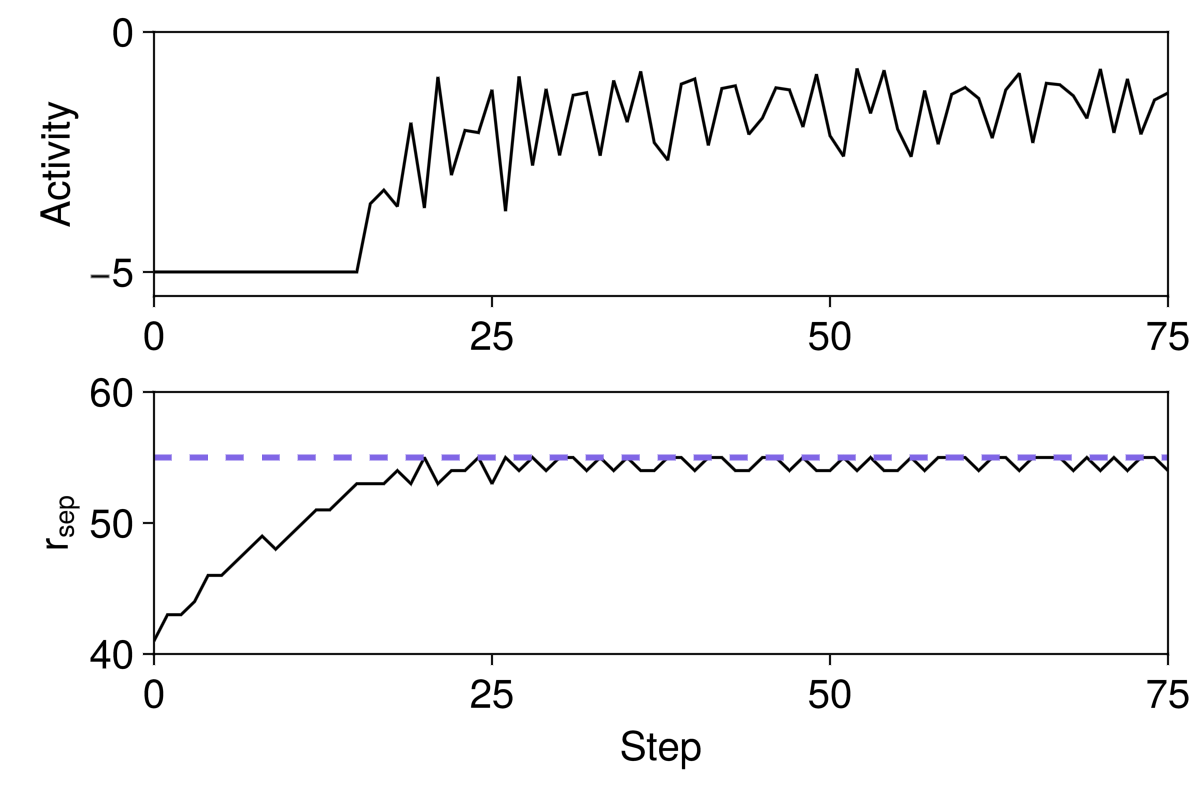

In [168]:
f = Figure(resolution = (600, 400), fontsize = 20, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    #xlabel = "Time",
    ylabel = "Activity",
    xgridvisible = false,
    ygridvisible = false,
    yticks = [-5,-0]
    
    )

Makie.xlims!(0,75)
Makie.ylims!(-5.5,0)
epNum = 4
t = 1
(velocityArray, nematicArray, activityArray, agentHandlerArray) = GetStateArrays(ex, epNum)

xvals = collect(0:75)
#Makie.scatter!(xvals, [activityArray[t].Values[argmax(abs.(activityArray[t].Values))] for t in 1:length(activityArray)], color = :black)
Makie.lines!(xvals,[activityArray[t].Values[argmax(abs.(activityArray[t].Values))] for t in 1:length(activityArray)], color = :black)

ax = Axis(f[2, 1],
    xlabel = "Step",
    #ylabel = "Separation",
    ylabel = rich("r", subscript("sep")),
    xgridvisible = false,
    ygridvisible = false,
    yticks = [40,50,60]
    )
Makie.xlims!(0,75)
Makie.ylims!(40,60)

sepList = []
for t in 1:length(agentHandlerArray)
    if (length(agentHandlerArray[t].PlusDefects) == 1) && (length(agentHandlerArray[t].MinusDefects) == 1)
        push!(sepList, agentHandlerArray[t].PlusDefects[1].Position[1] - agentHandlerArray[t].MinusDefects[1].Position[1])
    else
        println(ep)
    end
end
sepList = ModSep(sepList, 100)


colors = range(colorant"cyan3", stop=colorant"magenta1", length=5)

Makie.lines!(xvals, sepList, color = :black)
Makie.lines!(xvals, 55 .* ones(length(xvals)), color = colors[3], linestyle = :dash, linewidth = 3)

imagePath = "/Users/csfloyd/Dropbox/Projects/RLNematic/Figures/"
save(imagePath * "SepPlusActivitySeparation.png", f, px_per_unit = 3)


current_figure()

In [162]:
pathBase = "/Users/csfloyd/Dropbox/Projects/RLNematic/Dirs/AnalyzedData/"
pathName = pathBase * "separations_sepPlus_seed_l0_fin.jld2"

#@suppress_err d = load(pathName * "SavedData.jld2")
d = load(pathName)

varVec1 = FVF(sort(collect(keys(d["retDict"]))))
varVec2 = FVF(sort(collect(keys(d["retDict"][varVec1[3]]))));

8.0


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


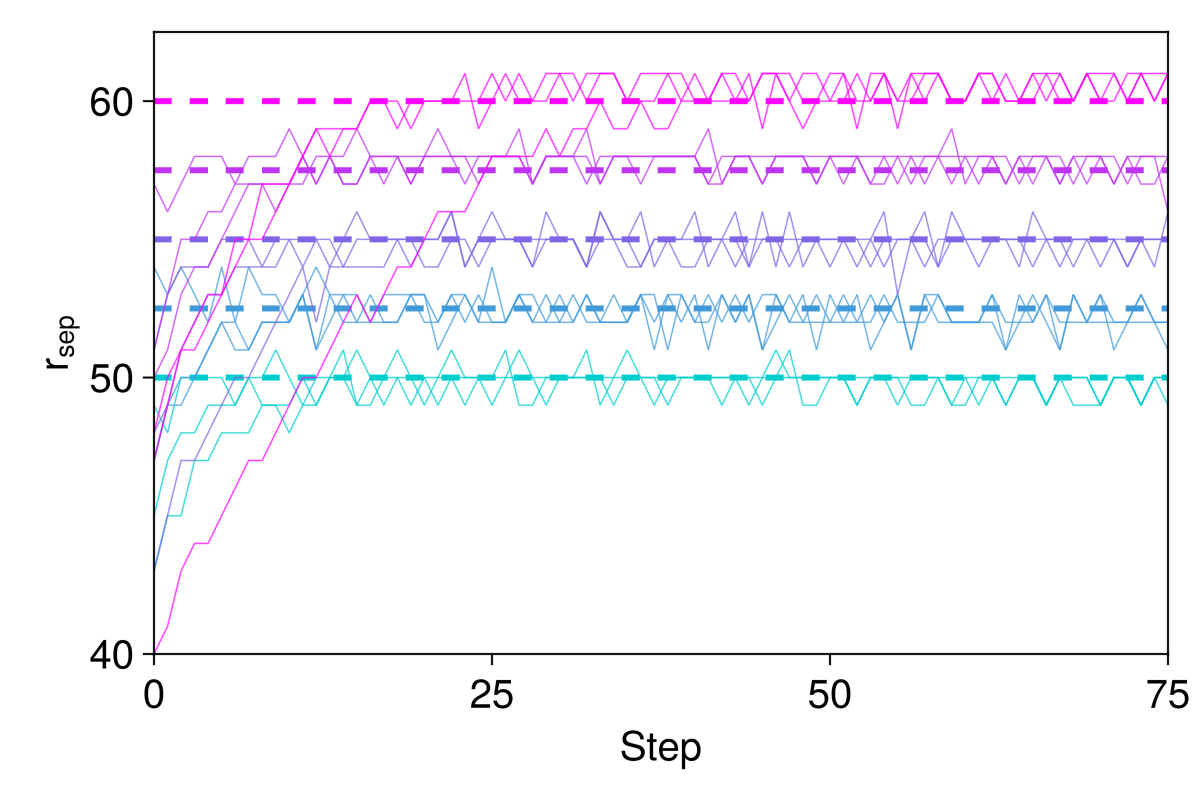

In [164]:
## horizontal separation
f = Figure(resolution = (600, 400), fontsize = 20, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    xlabel = "Step",
    ylabel = rich("r", subscript("sep")),
    xgridvisible = false,
    ygridvisible = false,
    yticks = [40,50,60]
    )

ksInd = 8;
sepList = d["retDict"][varVec1[5]][varVec2[ksInd]]
#sepList = d["retDict"][varVec1[5]]
println(varVec2[ksInd])

colors = range(colorant"cyan3", stop=colorant"magenta1", length=5)

ep1 = 1
ep2 = 30

ep1 = 148 - 0
ep2 = 150 - 0

expList = []
colorSet = Makie.wong_colors()

xVals = collect(0:75)
for n in 1:length(varVec1)
    Makie.lines!(xVals, varVec1[n] .* ones(length(xVals)), color= colors[n], alpha = 1, linewidth = 3, linestyle = :dash)
    
    sepList = d["retDict"][varVec1[n]][varVec2[ksInd]]
    for (i, ep) in enumerate(collect(ep1:ep2))
        sepListOrig = FVF(ModSep(sepList[ep],100))
        if length(sepListOrig) > 3
            #xVals = collect(0:length(sepListOrig)-1)
            Makie.lines!(xVals, sepListOrig, color= colors[n], alpha = 0.75, linewidth = 0.75)
        end
    end
    
end
Makie.xlims!(0,75)
Makie.ylims!(40,62.5)

imagePath = "/Users/csfloyd/Dropbox/Projects/RLNematic/Figures/"
save(imagePath * "SepPlusAllSeparations.png", f, px_per_unit = 3)


Makie.current_figure()

In [54]:
using LsqFit
using Statistics

meanVec = []
stdVec = []

ep1 = 100 
ep2 = 150


for l0 in varVec1
    means = []
    stds = []
    for seed in varVec2
            sepList = d["retDict"][l0][seed]
            expList = []
            for (i, ep) in enumerate(collect(ep1:length(sepList)))
                if length(sepList[ep]) > 75
                    yVals = FVF(ModSep(sepList[ep],100))
                    push!(expList, mean(yVals[50:75]))
                end
            end
            expList = sort(expList)[1:end]
            push!(means, mean(expList))
            push!(stds, std(expList)) 
    end
    push!(meanVec, means)
    push!(stdVec, stds)
end

In [ ]:
rₛₑₚ

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


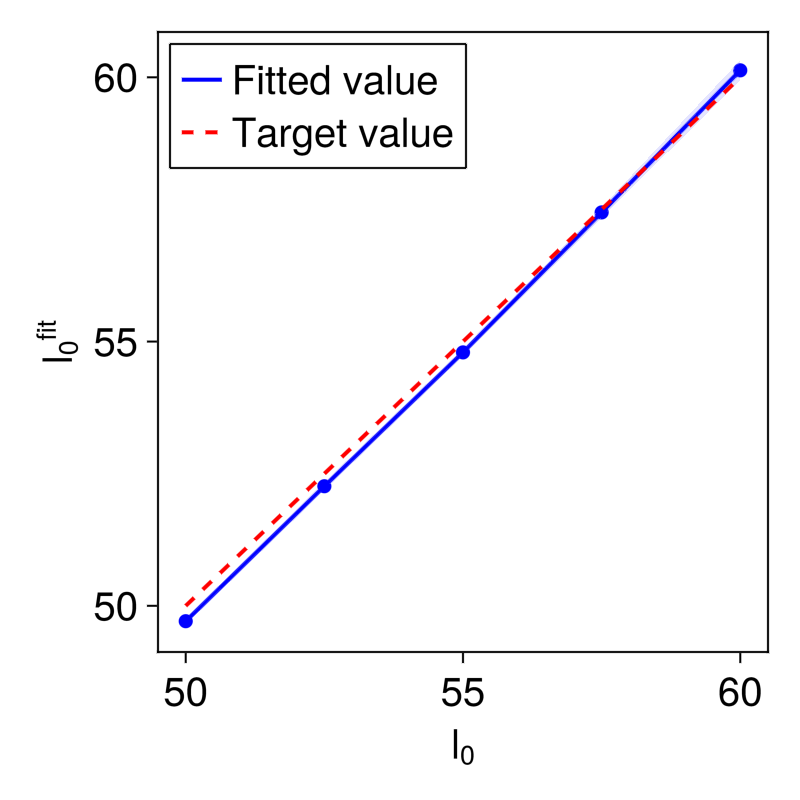

In [58]:
totMeanVec = []
totStdVec = []
for (i, ks) in enumerate(varVec1)
    push!(totMeanVec, mean(meanVec[i]))
    push!(totStdVec, sqrt.(sum(stdVec[i].^2)) ./ length(stdVec[i]))
end
totMeanVec = FVF(totMeanVec)
totStdVec = FVF(totStdVec)

f = Figure(resolution = (400, 400), fontsize = 20, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    xlabel = rich("l", subscript("0")),
    ylabel = rich("l", subscript("0"), superscript("fit")),
    xgridvisible = false,
    ygridvisible = false,
    xticks = [50,55,60],
    yticks = [50,55,60]
    )

lf = Makie.lines!(varVec1, totMeanVec, color = :blue, linewidth = 2)
Makie.scatter!(varVec1, totMeanVec, color = :blue, markersize = 10)
# Fill between the mean ± standard deviation

Makie.band!(varVec1, totMeanVec .- totStdVec, totMeanVec .+ totStdVec, color = :blue, alpha = 0.1)

lt = Makie.lines!(varVec1, varVec1, color = :red, linestyle = :dash, linewidth = 2)

axislegend(ax, [lf, lt], ["Fitted value", "Target value"], position = :lt)


imagePath = "/Users/csfloyd/Dropbox/Projects/RLNematic/Figures/"
save(imagePath * "SepPlusFits.png", f, px_per_unit = 3)

current_figure()

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


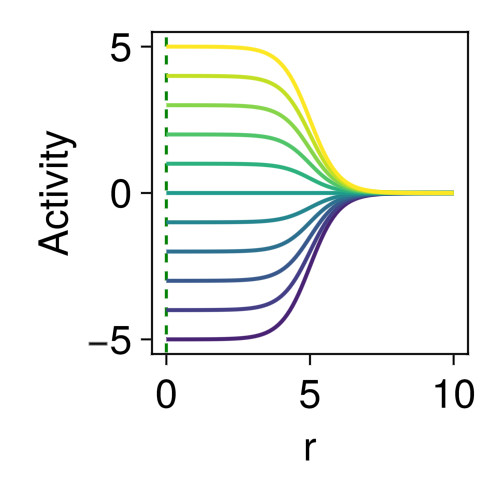

In [180]:
f = Figure(resolution = (250, 250), fontsize = 20, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    xlabel = "r",
    ylabel = "Activity",
    xgridvisible = false,
    ygridvisible = false,
    yticks = [-5,0,5]
    )

colormap = Makie.colorschemes[:viridis]
colorlist = collect(-5:1:5)
nc = length(colorlist)

Makie.vlines!(0; ymin = -10, ymax = 10, color = :green, linestyle = :dash)

for (i,f) in enumerate(colorlist)
    xVals = collect(0:0.1:10);
    yVals = FVF([f*Training.TanhBump(x, 1,5) for x in xVals])
    

    Makie.lines!(xVals, yVals, color = colormap[(i)/nc], linewidth = 2)
end

imagePath = "/Users/csfloyd/Dropbox/Projects/RLNematic/Figures/"
save(imagePath * "SepPlusActivityProfiles.png", f, px_per_unit = 3)

current_figure()

In [510]:
totStdVec

5-element Vector{Float64}:
 0.04946641651918647
 0.06529768991466336
 0.057700022359993976
 0.09914493042395076
 0.19225906660437267

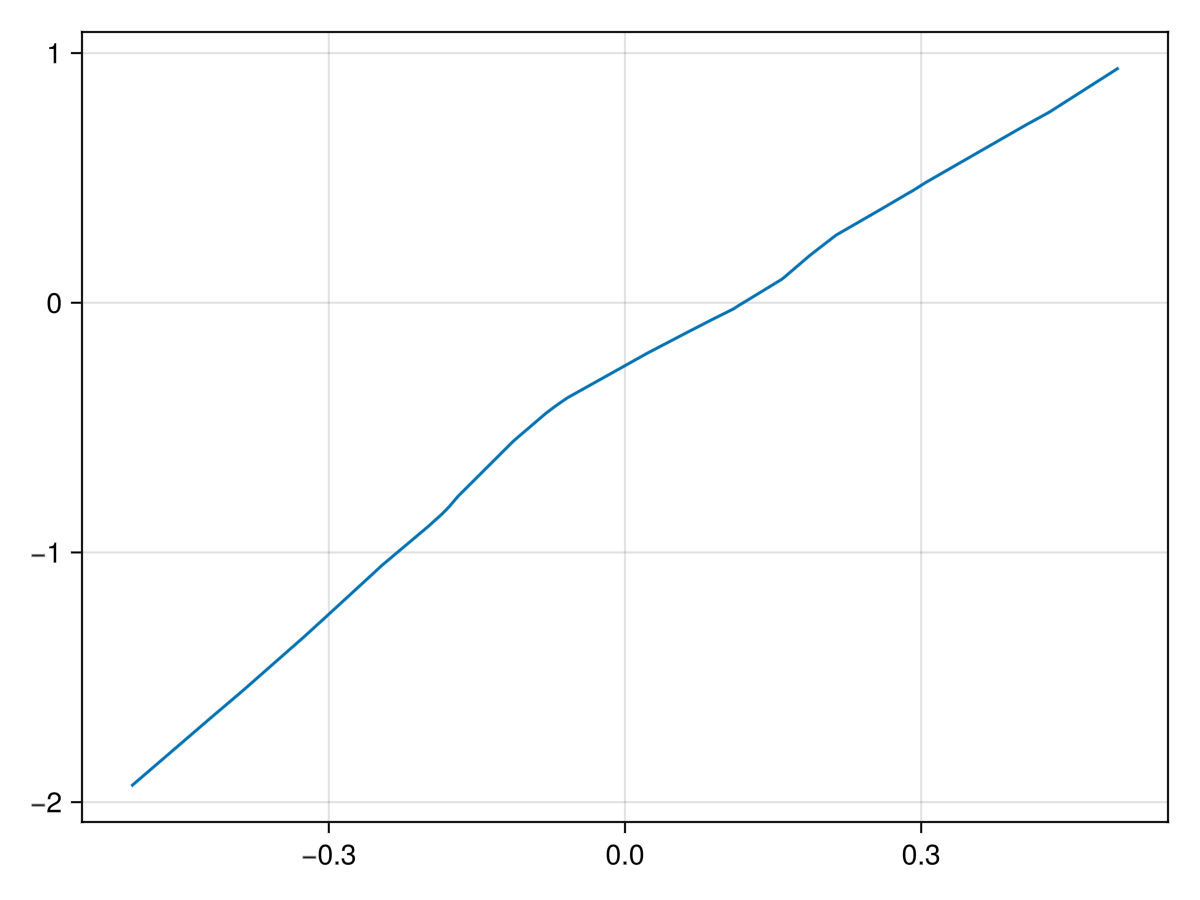

In [277]:
targetActions = []
behaviorActions = []

ps = collect(-0.5:0.001:0.5)

for p in ps
#     targetAction = ex.policy.policy.target_actor.model([0, p])[3]
#     behaviorAction = ex.policy.policy.behavior_actor.model([0, p])[3]
    
    targetAction = ex.policy.policy.target_actor.model([p])[1]
    behaviorAction = ex.policy.policy.behavior_actor.model([p])[1]
    
    push!(targetActions, targetAction[1])
    push!(behaviorActions, behaviorAction[1])
end

#Makie.lines(ps, Vector{Float64}(targetActions))
Makie.lines(ps, Vector{Float64}(behaviorActions))

p1 = - Vector{Float64}(behaviorActions)
current_figure()

# Plot sepMin figures

In [3]:
pathBase = "/Users/csfloyd/Dropbox/Projects/RLNematic/Dirs/Dirs_sepMin_ks"

ks = 0.0015

pathName = pathBase * "/ks_" * string(ks) * "/"


#@suppress_err d = load(pathName * "SavedData.jld2")
d = load(pathName * "SavedData.jld2")

parameters = d["parameters"];
ex = d["ex"];
hookResults = ex.hook.episodeList;


println("Done")

┌ Warning: saved type ADAM is missing field epsilon in workspace type; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/ryhNR/src/data/reconstructing_datatypes.jl:164


Done


In [9]:
f = Figure(resolution = (600, 400), fontsize = 20, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    #xlabel = "Time",
    ylabel = "Activity",
    xgridvisible = false,
    ygridvisible = false,
    yticks = [2,4,6]
    
    )

Makie.xlims!(ax, 0,75)
Makie.ylims!(ax, 2,6)
epNum = 3
t = 1
(velocityArray, nematicArray, activityArray, agentHandlerArray) = GetStateArrays(ex, epNum)

xvals = collect(0:75)

xvals = collect(0:length(activityArray)-1)

Makie.lines!(xvals,[activityArray[t].Values[argmax(abs.(activityArray[t].Values))] for t in 1:length(activityArray)], color = :black)


ax2 = Axis(f[1, 1], 
    ylabel = "r₋",
    xgridvisible = false,
    ygridvisible = false,
    yticklabelcolor = :red, 
    ytickcolor = :red, 
    ylabelcolor = :red,
    yaxisposition = :right,
    yticks = [-6,0,6])

Makie.xlims!(ax2, 0,75)
Makie.ylims!(ax2, -6,6)
hidespines!(ax2)
hidexdecorations!(ax2)
linkxaxes!(ax,ax2)


offVals = [argmax(abs.(activityArray[t].Values[1:end,50])) - agentHandlerArray[t].MinusDefects[1].Position[1] for t in 1:length(activityArray)]
Makie.lines!(ax2, xvals, offVals, color = :red)


ax = Axis(f[2, 1],
    xlabel = "Step",
    ylabel = rich("r", subscript("sep")),
    xgridvisible = false,
    ygridvisible = false,
    yticks = [40,50,60]
    )

sepList = []
for t in 1:length(agentHandlerArray)
    if (length(agentHandlerArray[t].PlusDefects) == 1) && (length(agentHandlerArray[t].MinusDefects) == 1)
        push!(sepList, agentHandlerArray[t].PlusDefects[1].Position[1] - agentHandlerArray[t].MinusDefects[1].Position[1])
    else
        println(ep)
    end
end
sepList = ModSep(sepList, 100)
Makie.xlims!(ax, 0,75)
Makie.ylims!(ax, 47.5,61)

colors = range(colorant"cyan3", stop=colorant"magenta1", length=5)


Makie.lines!(xvals, 50 .* ones(length(xvals)), color = colors[5], linestyle = :dash, linewidth = 3)

upFit = 75
yVals = FVF(sepList)
s0 = sepList[1]
linFun(t, p) = -(50.0 .- s0) .* exp.(-(t) .* p[1]) .+ 50.0
fitExp = curve_fit(linFun, xvals[1:upFit], yVals[1:upFit], [1e-2])
# Makie.lines!(xvals, FVF(linFun(xvals, fitExp.param)), 
#     linewidth = 3, color = (colors[5], 0.4))#, linestyle = :dash)

Makie.lines!(xvals, FVF(linFun(xvals, fitExp.param)), 
    linewidth = 1.5, color = (colors[5]), linestyle = :dash)

println(fitExp.param[1] / 50)

Makie.lines!(xvals, sepList, color = :black)

#imagePath = "/Users/csfloyd/Dropbox/Projects/RLNematic/Figures/"
#save(imagePath * "SepMinActivitySeparation.png", f, px_per_unit = 3)


current_figure()

0.002287743439477759


LoadError: `Makie.convert_arguments` for the plot type Lines{Tuple{Vector{Int64}, Vector{Any}}} and its conversion trait PointBased() was unsuccessful.

The signature that could not be converted was:
::Vector{Float32}, ::Vector{Any}

Makie needs to convert all plot input arguments to types that can be consumed by the backends (typically Arrays with Float32 elements).
You can define a method for `Makie.convert_arguments` (a type recipe) for these types or their supertypes to make this set of arguments convertible (See http://docs.makie.org/stable/documentation/recipes/index.html).

Alternatively, you can define `Makie.convert_single_argument` for single arguments which have types that are unknown to Makie but which can be converted to known types and fed back to the conversion pipeline.


In [53]:
pathBase = "/Users/csfloyd/Dropbox/Projects/RLNematic/Dirs/AnalyzedData/"
pathName = pathBase * "separations_sepMin_seed_ks_fin.jld2"


#@suppress_err d = load(pathName * "SavedData.jld2")
d = load(pathName)

varVec1 = FVF(sort(collect(keys(d["retDict"]))))
varVec2 = FVF(sort(collect(keys(d["retDict"][varVec1[3]]))));

println("Done")
length(varVec2)

Done


17

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


0.001
0.004


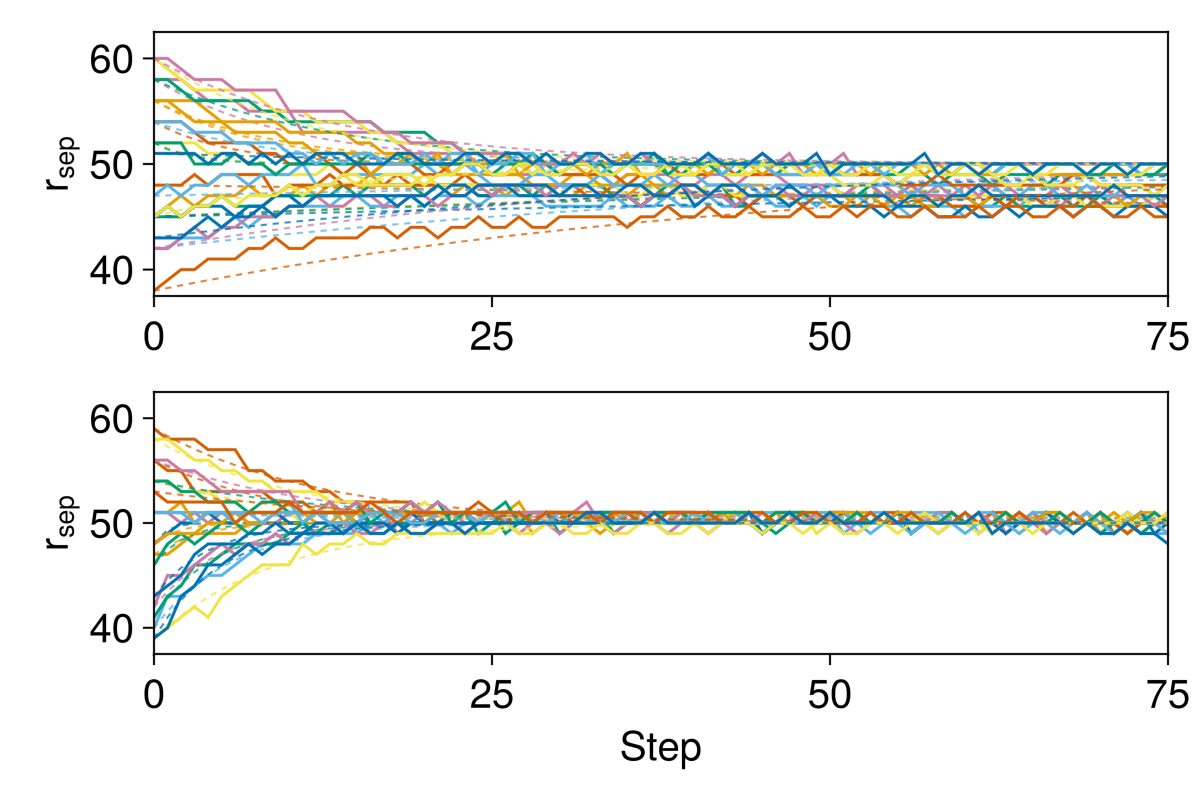

In [55]:
## horizontal separation

using LsqFit
using Statistics

f = Figure(resolution = (600, 400), fontsize = 20, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    #xlabel = "Time",
    ylabel = rich("r", subscript("sep")),
    xgridvisible = false,
    ygridvisible = false,
    yticks = [40,50,60]
    
    )

ep1 = 120 - 0
ep2 = 140 - 0


ksInd = 6;
sepList = d["retDict"][varVec1[2]][varVec2[ksInd]]
ksInd = 5;
sepList = d["retDict"][varVec1[8]][varVec2[ksInd]]
#sepList = d["retDict"][varVec1[5]]
println(varVec2[ksInd])

expList = []
colorSet = Makie.wong_colors()
colors = range(colorant"lightskyblue", stop=colorant"indigo", length=5)

upFit = 75;

for (i, ep) in enumerate(collect(ep1:ep2))
    colorIndex = i % length(colorSet)
    lineColor = colorSet[colorIndex + 1]
    #lineColor = colors[5]
    sepListOrig = FVF(abs.(sepList[ep]))
    if length(sepListOrig) > 3
        xVals = collect(0:length(sepListOrig)-1)
        s0 = sepListOrig[1]
        if (abs(s0-50) > 0) #&& (abs(s0-50) < 12.5)
            Makie.lines!(xVals, sepListOrig, color= lineColor)
            yVals = FVF(sepListOrig)
            linFun(t, p) = -(50.0 .- s0) .* exp.(-(t) .* p[1]) .+ 50.0
            fitExp = curve_fit(linFun, xVals[1:upFit], yVals[1:upFit], [1e-2])
            #fitExp = curve_fit(linFun, xVals, yVals, [1e-2])
            Makie.lines!(xVals, FVF(linFun(xVals, fitExp.param)), 
                linewidth = 1, color = (lineColor, 0.8), linestyle = :dash)
            push!(expList, fitExp.param[1] / 50)
        end
    end
end
Makie.xlims!(0,75)
Makie.ylims!(37.5, 62.5)


ax2 = Axis(f[2, 1],
    xlabel = "Step",
    ylabel = rich("r", subscript("sep")),
    xgridvisible = false,
    ygridvisible = false,
     yticks = [40,50,60]
    
    )

ksInd = 17;
#sepList = d["retDict"][varVec1[9]][varVec2[ksInd]]
sepList = d["retDict"][varVec1[9]][varVec2[ksInd]]
println(varVec2[ksInd])

for (i, ep) in enumerate(collect(ep1:ep2))
    colorIndex = i % length(colorSet)
    lineColor = colorSet[colorIndex + 1]
    #lineColor = colors[5]
    sepListOrig = FVF(abs.(sepList[ep]))
    if length(sepListOrig) > 3
        xVals = collect(0:length(sepListOrig)-1)
        s0 = sepListOrig[1]
        if (abs(s0-50) > 0) #&& (abs(s0-50) < 12.5)
            Makie.lines!(xVals, sepListOrig, color= lineColor)
            yVals = FVF(sepListOrig)
            linFun(t, p) = -(50.0 .- s0) .* exp.(-(t) .* p[1]) .+ 50.0
            fitExp = curve_fit(linFun, xVals[1:upFit], yVals[1:upFit], [1e-2])
            #fitExp = curve_fit(linFun, xVals, yVals, [1e-2])
            Makie.lines!(ax2, xVals, FVF(linFun(xVals, fitExp.param)), 
                linewidth = 1, color = (lineColor, 0.8), linestyle = :dash)
            push!(expList, fitExp.param[1] / 50)
        end
    end
end
Makie.xlims!(0,75)
Makie.ylims!(37.5, 62.5)

imagePath = "/Users/csfloyd/Dropbox/Projects/RLNematic/Figures/"
save(imagePath * "SepMinTrajectories.png", f, px_per_unit = 3)

Makie.current_figure()

In [205]:
using LsqFit
using Statistics

meanVec = []
stdVec = []

ep1 = 100 
ep2 = 140
upFit = 75


subSeedVec = [1,3,4,5,9]
subSeedVec = [2,3,4,5,6,7,9,10,11,12]
#subSeedVec = [1,2,3,4,5,6,8,9,10,11,12,13,14,15]
for ks in varVec2
    means = []
    stds = []
    for seed in subSeedVec
        try
            sepList = d["retDict"][seed][ks]
            expList = []
                for (i, ep) in enumerate(collect(ep1:length(sepList)))
                    sepListOrig = abs.(sepList[ep])
                    xVals = collect(0:length(sepListOrig)-1)
                    s0 = sepListOrig[1]
                    if (abs(s0-50.0) > 2) && length(sepListOrig)>60
                        yVals = FVF(sepListOrig)
                        linFun(t, p) = -(50.0 .- s0) .* exp.(-(t) .* p[1]) .+ 50.0
                        fitExp = curve_fit(linFun, xVals[1:upFit], yVals[1:upFit], [1e-2])
                        #fitExp = curve_fit(linFun, xVals, yVals, [1e-2])
                        push!(expList, fitExp.param[1] / 50)
                    end 
                end
                expList = sort(expList)[3:end-3]
                push!(means, mean(expList))
                push!(stds, std(expList))

        catch
        end
    end
    #println(ks)
    push!(meanVec, means)
    push!(stdVec, stds)
end

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


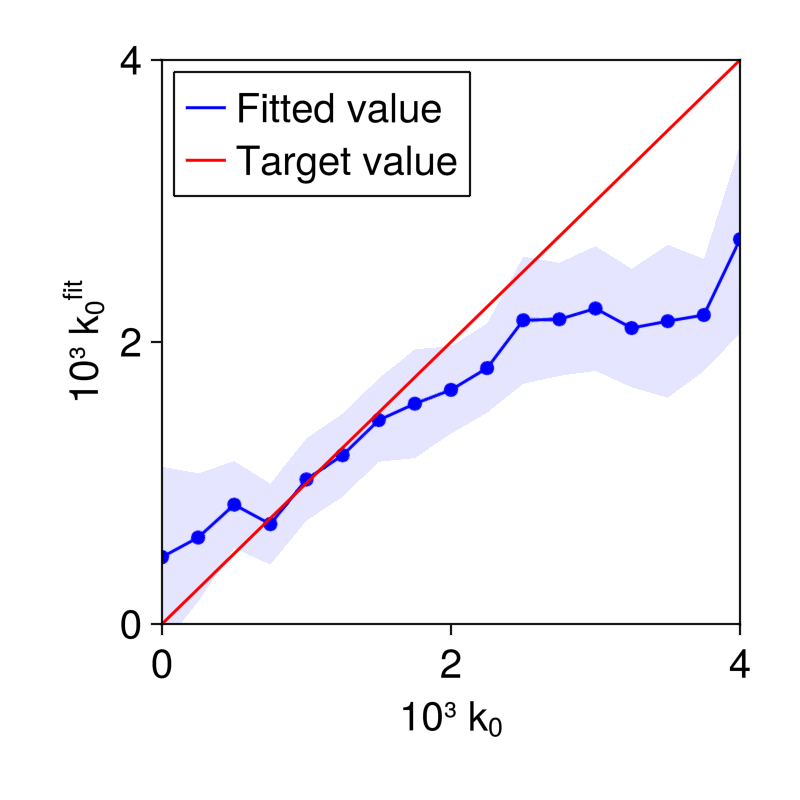

In [209]:
using Statistics

totMeanVec = []
totStdVec = []
for (i, ks) in enumerate(varVec2)
    push!(totMeanVec, mean(meanVec[i]))
    push!(totStdVec, sqrt.(sum(stdVec[i].^2)) ./ length(stdVec[i]))
end
totMeanVec = FVF(totMeanVec)
totStdVec = FVF(totStdVec)

ffac = 10^3

f = Figure(resolution = (400, 400), fontsize = 20, font = "Arial", dpi = 300, figure_padding = 30)
ax = Axis(f[1, 1],
    xlabel = rich("10³ k", subscript("0")),
    ylabel = rich("10³ k", subscript("0"), superscript("fit")),
    xgridvisible = false,
    ygridvisible = false,
    # yticks = [0, 0.002, 0.004],
    # xticks = [0, 0.002, 0.004]
    yticks = [0, 2, 4],
    xticks = [0, 2, 4]
    )

Makie.xlims!(0,4)
Makie.ylims!(0,4)

lf = Makie.lines!(ffac .* varVec2, ffac .* totMeanVec, color = :blue)
Makie.scatter!(ffac .* varVec2, ffac .* totMeanVec, color = :blue, markersize = 10)

# Fill between the mean ± standard deviation
Makie.band!(ffac .* varVec2, ffac .* (totMeanVec .- totStdVec), ffac .* (totMeanVec .+ totStdVec), color = :blue, alpha = 0.1)

lt = Makie.lines!(ffac .* varVec2, ffac .* varVec2, color = :red)

axislegend(ax, [lf, lt], ["Fitted value", "Target value"], position = :lt)

imagePath = "/Users/csfloyd/Dropbox/Projects/RLNematic/Figures/"
save(imagePath * "SepMinFits.png", f, px_per_unit = 3)

current_figure()

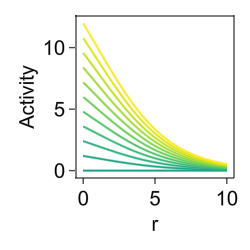

In [10]:
f = Figure(resolution = (250, 250), fontsize = 20, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    xlabel = "r",
    ylabel = "Activity",
    xgridvisible = false,
    ygridvisible = false,
    yticks = [0,5,10]
    )

colormap = Makie.colorschemes[:viridis]
colorlist = collect(0:2:20)
nc = length(colorlist)*2

for (i,f) in enumerate(colorlist)
    xVals = collect(0:0.1:10);
    yVals = FVF([f*Training.TanhBump(x, 5,1) for x in xVals])
    

    Makie.lines!(xVals, yVals, color = colormap[0.5 + i/nc], linewidth = 2)
end

#imagePath = "/Users/csfloyd/Dropbox/Projects/RLNematic/Figures/"
#save(imagePath * "SepMinActivityProfiles.png", f, px_per_unit = 3)

current_figure()

In [12]:
7.5*Training.TanhBump(0, 5,1)

4.49015745084339

# Plot orPlus figures

In [174]:
pathBase = "/Users/csfloyd/Dropbox/Projects/RLNematic/Dirs/Dirs_orPlus_ks"
ks = 0.0007
pathName = pathBase * "/ks_" * string(ks) * "/"


@suppress_err d = load(pathName * "SavedData.jld2")
#d = load(pathName * "SavedData.jld2")

parameters = d["parameters"];
ex = d["ex"];
hookResults = ex.hook.episodeList;

println("Done")

Done


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


0.0006688754017267708


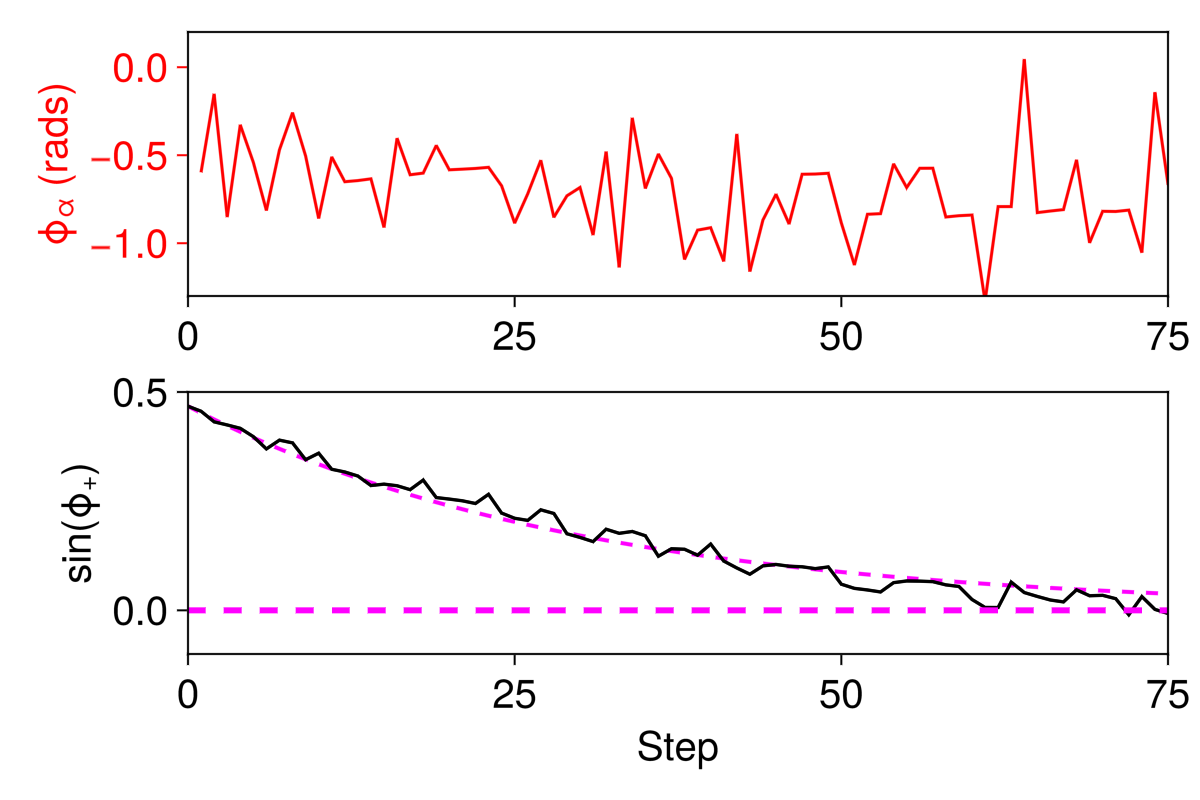

In [176]:
f = Figure(resolution = (600, 400), fontsize = 20, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    #xlabel = "Time",
    ylabel = rich("ϕ", subscript("α"), " (rads)"),
    xgridvisible = false,
    ygridvisible = false,
    yticklabelcolor = :red,
    ytickcolor = :red,
    ylabelcolor = :red,
    yticks = [-1,-0.5,0]
    
    )

Makie.xlims!(0,75)
Makie.ylims!(-1.3,0.2)
epNum = 2
t = 1
(velocityArray, nematicArray, activityArray, agentHandlerArray) = GetStateArrays(ex, epNum)

xvals = collect(0:75)
#Makie.scatter!(xvals, [activityArray[t].Values[argmax(abs.(activityArray[t].Values))] for t in 1:length(activityArray)], color = :black)
Makie.lines!(xvals,[activityArray[t].Values[argmax(abs.(activityArray[t].Values))] for t in 1:length(activityArray)], color = :black)

vecs = [[argmax(abs.(activityArray[t].Values))[1], argmax(abs.(activityArray[t].Values))[2]] .- agentHandlerArray[t].PlusDefects[1].Position for t in 1:length(activityArray)]
vecs = [vec ./ sqrt(vec[1]^2 + vec[2]^2) for vec in vecs]
offOrs = [atan(vec[2],vec[1]) for vec in vecs]
offOrs = offOrs .- [agentHandlerArray[t].PlusDefects[1].Orientation for t in 1:length(activityArray)]
Makie.lines!(offOrs, color = :red)


ax = Axis(f[2, 1],
    xlabel = "Step",
    ylabel = rich("sin(","ϕ", subscript("+"), ")"),
    xgridvisible = false,
    ygridvisible = false,
    yticks = [-0.5,0,0.5]
    )
Makie.xlims!(0,75)
Makie.ylims!(-0.1,0.5)

sepList = []
for t in 1:length(agentHandlerArray)
    if (length(agentHandlerArray[t].PlusDefects) == 1) && (length(agentHandlerArray[t].MinusDefects) == 1)
        #push!(sepList, agentHandlerArray[t].PlusDefects[1].Position[1] - agentHandlerArray[t].MinusDefects[1].Position[1])
        push!(sepList, sin(agentHandlerArray[t].PlusDefects[1].Orientation))
    else
        println(ep)
    end
end
#sepList = ModSep(sepList, 100)

colors = range(colorant"cyan3", stop=colorant"magenta1", length=5)

upFit = 75
yVals = FVF(sepList)
s0 = sepList[1]
linFun(t, p) = s0 .* exp.(-(t) .* p[1]) 
fitExp = curve_fit(linFun, xvals[1:upFit], yVals[1:upFit], [1e-2])
Makie.lines!(xvals, FVF(linFun(xvals, fitExp.param)), 
    linewidth = 2, color = (colors[5]), linestyle = :dash)

println(fitExp.param[1] / 50)

Makie.lines!(xvals, sepList, color = :black)



Makie.lines!(xvals, sepList, color = :black)
Makie.lines!(xvals, 0 .* ones(length(xvals)), color = colors[5], linestyle = :dash, linewidth = 3)

imagePath = "/Users/csfloyd/Dropbox/Projects/RLNematic/Figures/"
save(imagePath * "OrPlusPhialphaOrientation.png", f, px_per_unit = 3)


current_figure()

In [25]:
pathBase = "/Users/csfloyd/Dropbox/Projects/RLNematic/Dirs/AnalyzedData/"
pathName = pathBase * "orientations_orPlus_seed_ks_fin.jld2"


#@suppress_err d = load(pathName * "SavedData.jld2")
d = load(pathName)

varVec1 = FVF(sort(collect(keys(d["retDict"]))))
varVec2 = FVF(sort(collect(keys(d["retDict"][varVec1[3]]))));

println("Done")
length(varVec2)

Done


17

0.00025


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


0.0008


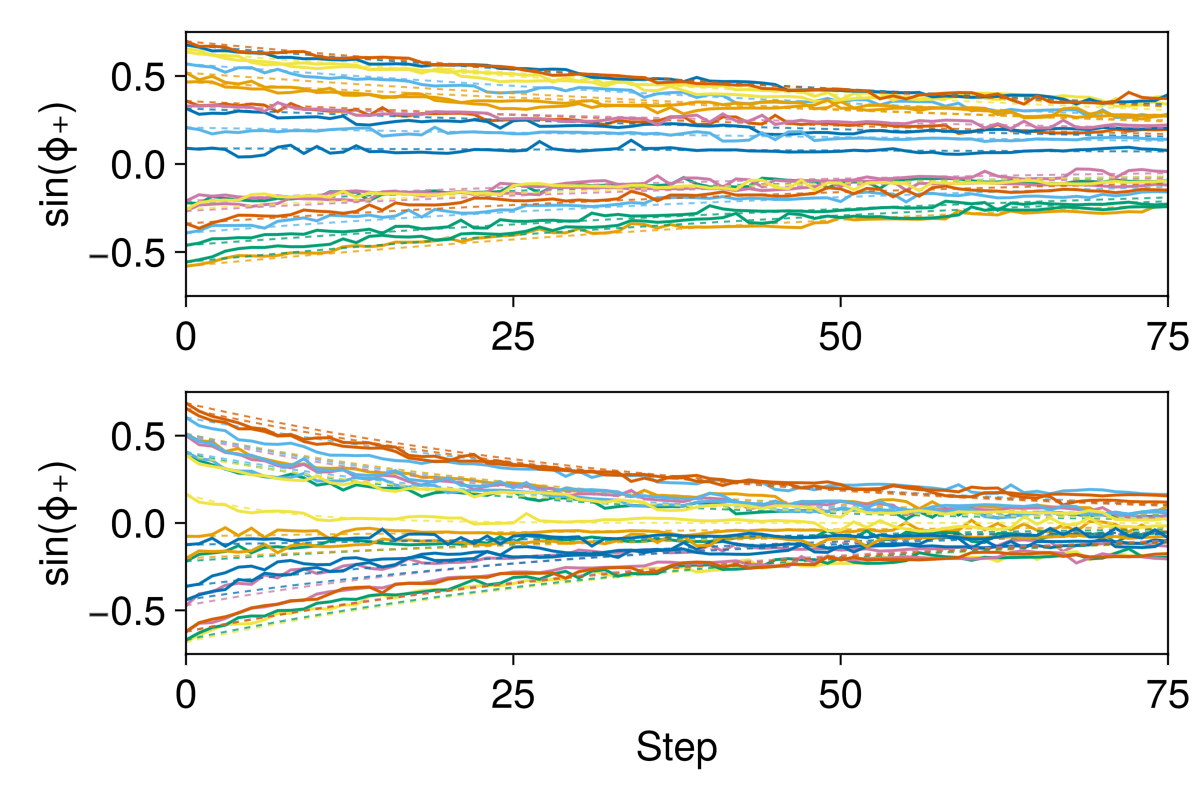

In [33]:
## horizontal separation

using LsqFit
using Statistics

f = Figure(resolution = (600, 400), fontsize = 20, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    #xlabel = "Time",
    ylabel = "sin(ϕ₊)",
    xgridvisible = false,
    ygridvisible = false,
    yticks = [-0.5,0,0.5]
    
    )

ep1 = 120 - 0
ep2 = 140 - 0


ksInd = 6;
sepList = d["retDict"][varVec1[12]][varVec2[ksInd]]
#sepList = d["retDict"][varVec1[5]]
println(varVec2[ksInd])

expList = []
colorSet = Makie.wong_colors()
colors = range(colorant"lightskyblue", stop=colorant"indigo", length=5)

upFit = 75;

for (i, ep) in enumerate(collect(ep1:ep2))
    colorIndex = i % length(colorSet)
    lineColor = colorSet[colorIndex + 1]
    #lineColor = colors[5]
    sepListOrig = FVF(sin.(sepList[ep]))
    if length(sepListOrig) > 3
        xVals = collect(0:length(sepListOrig)-1)
        s0 = sepListOrig[1]
        if abs(sepListOrig[1]) > 0.0
            Makie.lines!(xVals, sepListOrig, color= lineColor)
            yVals = sepListOrig
            linFun(t, p) = yVals[1] *  exp.(-t .* p[1])
            fitExp = curve_fit(linFun, xVals, yVals, [1.0, 1e-1])
            Makie.lines!(xVals, FVF(linFun(xVals, fitExp.param)), 
                linewidth = 1, color = (lineColor, 0.8), linestyle = :dash)
        end
    end
end
Makie.xlims!(0,75)
Makie.ylims!(-0.75, 0.75)


ax2 = Axis(f[2, 1],
    xlabel = "Step",
    ylabel = "sin(ϕ₊)",
    xgridvisible = false,
    ygridvisible = false,
    yticks = [-0.5,0,0.5]
    
    )

ksInd = 17;
#sepList = d["retDict"][varVec1[9]][varVec2[ksInd]]
sepList = d["retDict"][varVec1[3]][varVec2[ksInd]]
println(varVec2[ksInd])

for (i, ep) in enumerate(collect(ep1:ep2))
    colorIndex = i % length(colorSet)
    lineColor = colorSet[colorIndex + 1]
    #lineColor = colors[5]
    sepListOrig = FVF(sin.(sepList[ep]))
    if length(sepListOrig) > 3
        xVals = collect(0:length(sepListOrig)-1)
        s0 = sepListOrig[1]
        if abs(sepListOrig[1]) > 0.0
            Makie.lines!(xVals, sepListOrig, color= lineColor)
            yVals = sepListOrig
            linFun(t, p) = yVals[1] *  exp.(-t .* p[1])
            fitExp = curve_fit(linFun, xVals, yVals, [1.0, 1e-1])
            Makie.lines!(xVals, FVF(linFun(xVals, fitExp.param)), 
                linewidth = 1, color = (lineColor, 0.8), linestyle = :dash)
        end
    end
end
Makie.xlims!(0,75)
Makie.ylims!(-0.75, 0.75)

imagePath = "/Users/csfloyd/Dropbox/Projects/RLNematic/Figures/"
save(imagePath * "OrPlusTrajectories.png", f, px_per_unit = 3)

Makie.current_figure()

In [47]:
# using LsqFit
using Statistics

meanVec = []
stdVec = []

ep1 = 100
ep2 = 140

subSeedVec = [2,3,4,5,6,7,9,10,11,12]
#subSeedVec = [2,3,4,5,6]
for ks in varVec2
    means = []
    stds = []
    for seed in subSeedVec
        try
            orList = d["retDict"][seed][ks]
            expList = []
                for (i, ep) in enumerate(collect(ep1:length(orList)))
                    s0ListOrig = sin.(orList[ep])
                    if abs(s0ListOrig[1]) > 0.1
                        xVals = collect(1:length(s0ListOrig))
                        yVals = s0ListOrig
                        linFun(t, p) = yVals[1] *  exp.(-t .* p[1])
                        fitExp = curve_fit(linFun, xVals, yVals, [1.0, 1e-1])
                        if abs(fitExp.param[1] / 50) < 0.01
                            push!(expList, fitExp.param[1] / 50)
                        end
                    end 
                end
                expList = sort(expList)[3:end-3]
                push!(means, mean(expList))
                push!(stds, std(expList))
        catch
        end
        
    end
    push!(meanVec, means)
    push!(stdVec, stds)
end


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


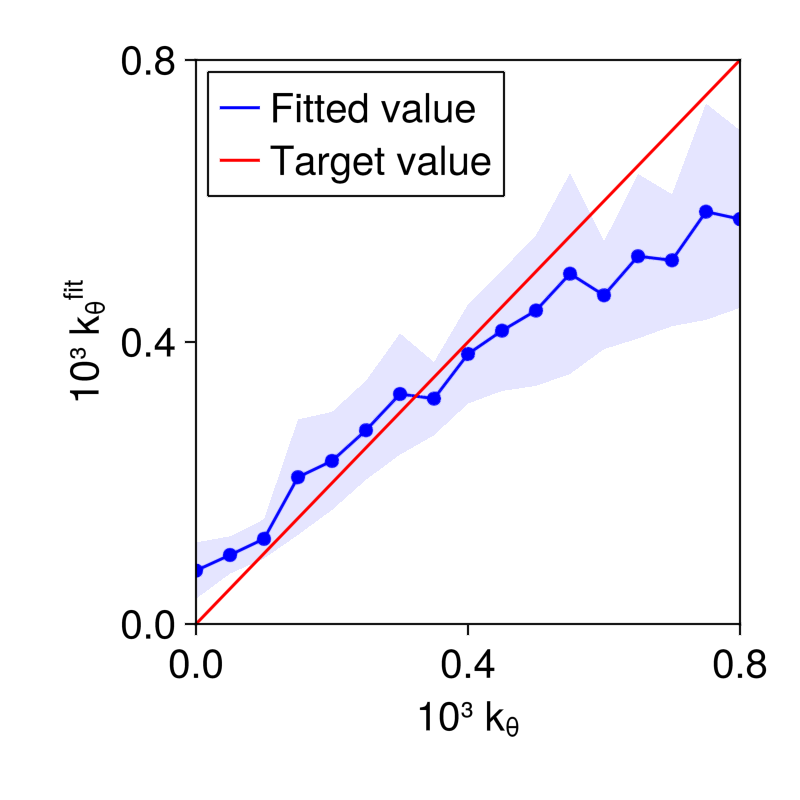

In [51]:
using Statistics

totMeanVec = []
totStdVec = []
for (i, ks) in enumerate(varVec2)
    push!(totMeanVec, mean(meanVec[i]))
    push!(totStdVec, sqrt.(sum(stdVec[i].^2)) ./ length(stdVec[i]))
end
totMeanVec = FVF(totMeanVec)
totStdVec = FVF(totStdVec)

ffac = 10^3

f = Figure(resolution = (400, 400), fontsize = 20, font = "Arial", dpi = 300, figure_padding = 30)
ax = Axis(f[1, 1],
    xlabel = rich("10³ k", subscript("θ")),
    ylabel = rich("10³ k", subscript("θ"), superscript("fit")),
    xgridvisible = false,
    ygridvisible = false,
    # yticks = [0, 0.002, 0.004],
    # xticks = [0, 0.002, 0.004]
    yticks = [0, 0.4, 0.8],
    xticks = [0, 0.4, 0.8]
    )

Makie.xlims!(0,0.8)
Makie.ylims!(0,0.8)

lf = Makie.lines!(ffac .* varVec2, ffac .* totMeanVec, color = :blue)
Makie.scatter!(ffac .* varVec2, ffac .* totMeanVec, color = :blue, markersize = 10)

# Fill between the mean ± standard deviation
Makie.band!(ffac .* varVec2, ffac .* (totMeanVec .- totStdVec), ffac .* (totMeanVec .+ totStdVec), color = :blue, alpha = 0.1)

lt = Makie.lines!(ffac .* varVec2, ffac .* varVec2, color = :red)

axislegend(ax, [lf, lt], ["Fitted value", "Target value"], position = :lt)

imagePath = "/Users/csfloyd/Dropbox/Projects/RLNematic/Figures/"
save(imagePath * "OrPlusFit.png", f, px_per_unit = 3)

current_figure()

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


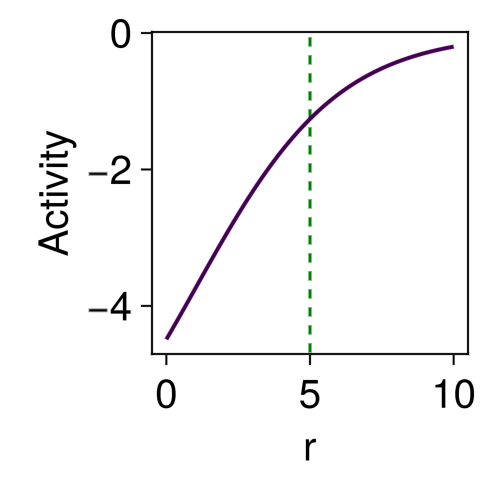

In [178]:
f = Figure(resolution = (250, 250), fontsize = 20, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    xlabel = "r",
    ylabel = "Activity",
    xgridvisible = false,
    ygridvisible = false,
    yticks = [-4,-2,0]
    )

colormap = Makie.colorschemes[:viridis]
colorlist = collect(0:2:20)
nc = length(colorlist)*2
Makie.vlines!(5; ymin = -10, ymax = 10, color = :green, linestyle = :dash)

#for (i,f) in enumerate(colorlist)
    xVals = collect(0:0.1:10);
    yVals = FVF([-7.5 * Training.TanhBump(x, 5,1) for x in xVals])
    

    Makie.lines!(xVals, yVals, color = colormap[1], linewidth = 2)
#end



imagePath = "/Users/csfloyd/Dropbox/Projects/RLNematic/Figures/"
save(imagePath * "OrPlusActivityProfiles.png", f, px_per_unit = 3)

current_figure()

# Plot orientation trajectories

In [5]:
pathBase = "/Users/csfloyd/Dropbox/Projects/RLNematic/Dirs/AnalyzedData/"
pathName = pathBase * "orientation_seed_ks_rel.jld2"
pathName = pathBase * "orientations_batchSize_rel.jld2"
#pathName = pathBase * "orientations_gamma_rel.jld2"
#pathName = pathBase * "orientations_rho_rel.jld2"
#pathName = pathBase * "orientations_seed_rho_rel.jld2"
#pathName = pathBase * "orientations_netLayers_rel.jld2"
#pathName = pathBase * "orientations_learningRate_rel.jld2"
pathName = pathBase * "orientations_seed_ks_fin.jld2"
pathName = pathBase * "orientations_followers_seed_rewT.jld2"
#pathName = pathBase * "separations_sepMin_seed_ks_2.jld2"
#pathName = pathBase * "separations_sepPlus_seed_ks_2.jld2"
#pathName = pathBase * "separations_sepPlus_seed_ks_rot_full.jld2"

#@suppress_err d = load(pathName * "SavedData.jld2")
d = load(pathName)

varVec1 = FVF(sort(collect(keys(d["retDict"]))))
varVec2 = FVF(sort(collect(keys(d["retDict"][varVec1[3]]))));

println("Done")
length(varVec2)

Done


2

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/iRM0c/src/scenes.jl:220


0.00175
0.0007561023206252688
0.00032537096071817126


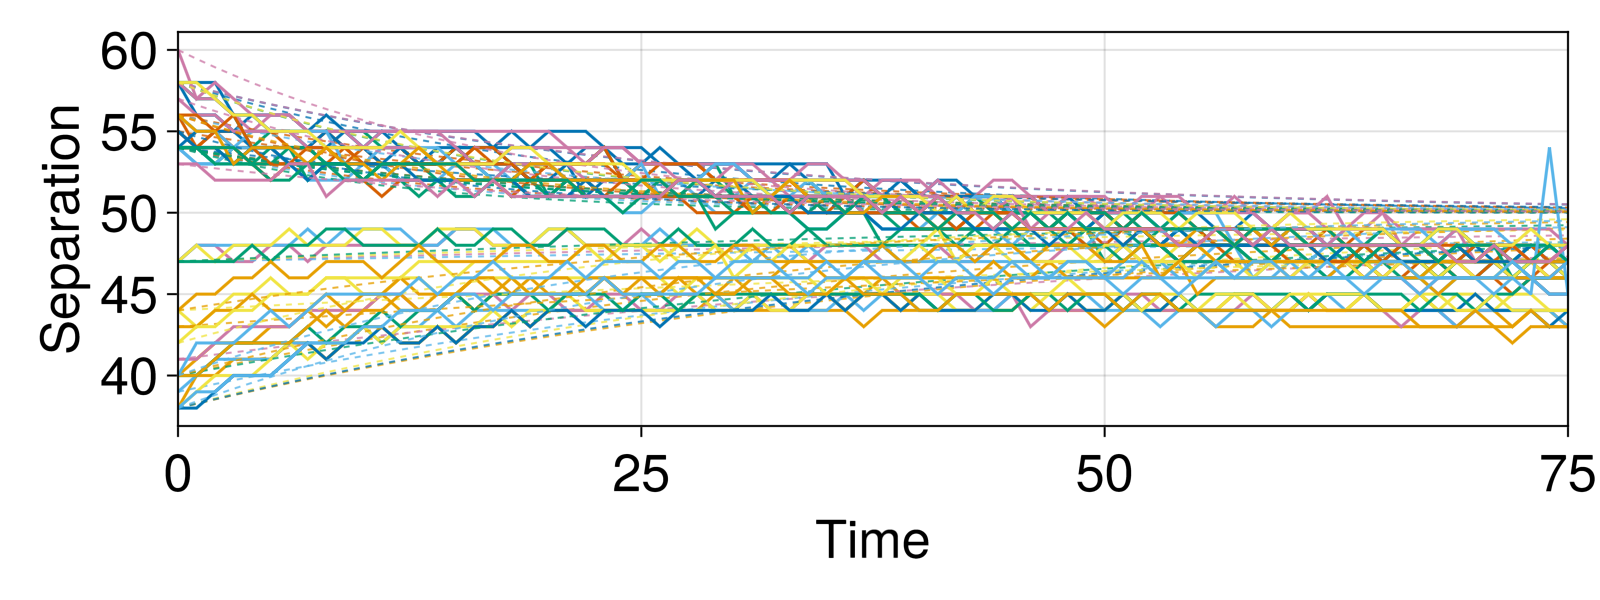

In [350]:
## horizontal separation

using LsqFit
using Statistics

f = Figure(resolution = (800, 300), fontsize = 26, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    xlabel = "Time",
    ylabel = "Separation"
    )

ksInd = 8;
sepList = d["retDict"][varVec1[5]][varVec2[ksInd]]
#sepList = d["retDict"][varVec1[5]]
println(varVec2[ksInd])

ep1 = 1
ep2 = 30

ep1 = 100 - 0
ep2 = 145 - 0

expList = []
colorSet = Makie.wong_colors()
upFit = 50;

for (i, ep) in enumerate(collect(ep1:ep2))
    colorIndex = i % length(colorSet)
    lineColor = colorSet[colorIndex + 1]
    #sepListOrig = FVF(abs.(sepList[ep]))
    sepListOrig = FVF(abs.(sepList[ep]))
    if length(sepListOrig) > 3
        xVals = collect(0:length(sepListOrig)-1)
        s0 = sepListOrig[1]
        
        if (abs(s0-50) > 2) #&& (abs(s0-50) < 10)
            Makie.lines!(xVals, sepListOrig, color= lineColor)
            yVals = FVF(sepListOrig)
            linFun(t, p) = -(50.0 .- s0) .* exp.(-(t) .* p[1]) .+ 50.0
            fitExp = curve_fit(linFun, xVals[1:upFit], yVals[1:upFit], [1e-2])
            #fitExp = curve_fit(linFun, xVals, yVals, [1e-2])
            Makie.lines!(xVals, FVF(linFun(xVals, fitExp.param)), 
                linewidth = 1, color = (lineColor, 0.8), linestyle = :dash)
            push!(expList, fitExp.param[1] / 50)
        end
    end


end
Makie.xlims!(0,75)
#Makie.ylims!(40, 60)

expList = sort(expList)[2:end-2]
println(mean(expList))
println(std(expList))
#println(maximum(expList))
Makie.current_figure()

In [12]:
using LsqFit
using Statistics

meanVec = []
stdVec = []

ep1 = 80 
ep2 = 10
upFit = 50;


subSeedVec = [2,3,4,5,6,7,9,10,11,12]
#subSeedVec = [2,3,4,6,7]
#subSeedVec = [7,9,10,11,12]
#subSeedVec = [1,2,3,4,5,6,7,8,9,10]#,11,12,13,14,15]
subSeedVec = [1,3,4,5,9]
for ks in varVec2
    means = []
    stds = []
    for seed in subSeedVec
        #try
            sepList = d["retDict"][seed][ks]
            expList = []
            #if length(sepList) > ep2
                for (i, ep) in enumerate(collect(ep1:length(sepList)))
                    sepListOrig = abs.(sepList[ep])
                    xVals = collect(0:length(sepListOrig)-1)
                    s0 = sepListOrig[1]
                    if (abs(s0-50.0) > 2) && length(sepListOrig)>50
                        yVals = FVF(sepListOrig)
                        linFun(t, p) = -(50.0 .- s0) .* exp.(-(t) .* p[1]) .+ 50.0
                        #fitExp = curve_fit(linFun, xVals[1:upFit], yVals[1:upFit], [1e-2])
                        fitExp = curve_fit(linFun, xVals, yVals, [1e-2])
                        push!(expList, fitExp.param[1] / 50)
                    end 
                end
                expList = sort(expList)[2:end-2]
                push!(means, mean(expList))
                push!(stds, std(expList))
                
            #else
               
                #println(ks, " ", seed)
                #println(length(orList))
            #end
        #catch
        #end
        #println(argmax(means))
        #println(argmin(means))
        
    end
    push!(meanVec, means)
    push!(stdVec, stds)
end

In [47]:
ksVec = [0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004]

9-element Vector{Float64}:
 0.0
 0.0005
 0.001
 0.0015
 0.002
 0.0025
 0.003
 0.0035
 0.004

In [69]:
meanVec

5-element Vector{Any}:
 Any[0.00579439905467424, 0.0057447415530778615, 0.006823644575160891]
 Any[0.00579439905467424, 0.0057447415530778615, 0.006823644575160891]
 Any[0.00579439905467424, 0.0057447415530778615, 0.006823644575160891]
 Any[0.00579439905467424, 0.0057447415530778615, 0.006823644575160891]
 Any[0.00579439905467424, 0.0057447415530778615, 0.006823644575160891]

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


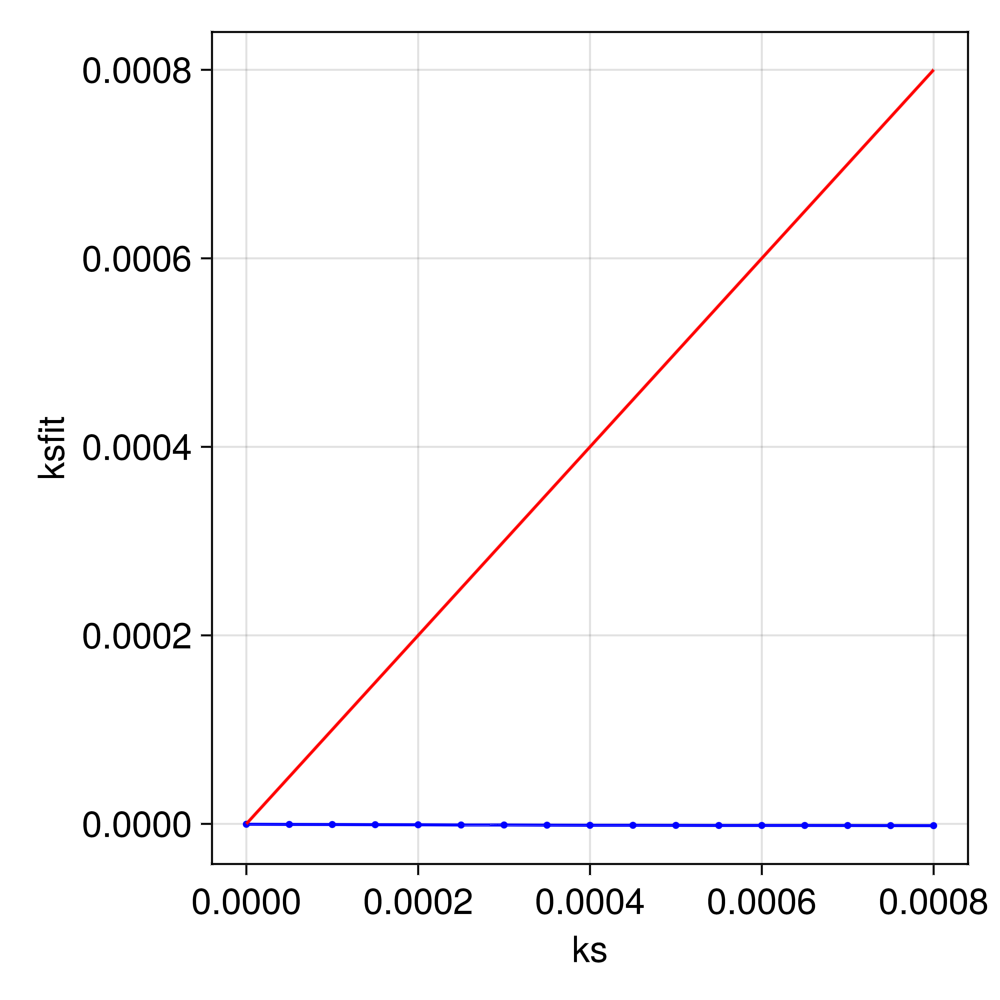

In [14]:
using Statistics

totMeanVec = []
totStdVec = []
for (i, ks) in enumerate(varVec2)
    push!(totMeanVec, mean(meanVec[i]))
    push!(totStdVec, sqrt.(sum(stdVec[i].^2)) ./ length(stdVec[i]))
end
totMeanVec = FVF(totMeanVec)
totStdVec = FVF(totStdVec)

f = Figure(resolution = (500, 500), fontsize = 18, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    xlabel = "ks",
    ylabel = "ksfit"
    )

Makie.lines!(varVec2, totMeanVec, color = :blue)
Makie.scatter!(varVec2, totMeanVec, color = :blue, markersize = 5)
# Makie.errorbars!(varVec2, totMeanVec, totStdVec)

# Fill between the mean ± standard deviation
Makie.band!(varVec2, totMeanVec .- totStdVec, totMeanVec .+ totStdVec, color = :blue, alpha = 0.1)
#
Makie.lines!(varVec2, varVec2, color = :red)
#Makie.scatter!(varVec2, varVec2, color = :red)
#Makie.ylims!(0,0.005)

current_figure()

In [3]:
pathBase = "/Users/csfloyd/Dropbox/Projects/RLNematic/Dirs/AnalyzedData/"
pathName = pathBase * "orientation_seed_ks_rel.jld2"
pathName = pathBase * "orientations_batchSize_rel.jld2"
#pathName = pathBase * "orientations_gamma_rel.jld2"
#pathName = pathBase * "orientations_rho_rel.jld2"
#pathName = pathBase * "orientations_seed_rho_rel.jld2"
#pathName = pathBase * "orientations_netLayers_rel.jld2"
#pathName = pathBase * "orientations_learningRate_rel.jld2"
pathName = pathBase * "orientations_seed_ks_rel_4_full.jld2"
pathName = pathBase * "orientations_followers_seed_rewT_2.jld2"
#pathName = pathBase * "separations_sepMin_seed_ks_2.jld2"

#@suppress_err d = load(pathName * "SavedData.jld2")
d = load(pathName)

varVec1 = FVF(sort(collect(keys(d["retDict"]))))
varVec2 = FVF(sort(collect(keys(d["retDict"][varVec1[2]]))));

println("Done")
length(varVec2)

Done


3

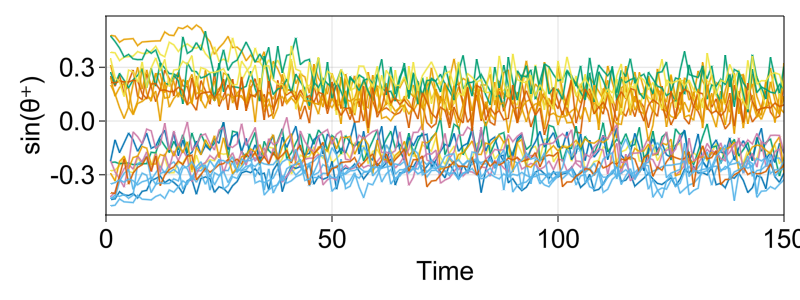

In [21]:
## Plus orientations

using LsqFit

f = Figure(resolution = (800, 300), fontsize = 26, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    xlabel = "Time",
    ylabel = "sin(θ⁺)"
    )

#orList = d["retDict"][seedVec[6]][ksVec[5]]
#println(varVec[1])
#orList = d["retDict"][varVec1[4]]
orList = d["retDict"][varVec1[1]][varVec2[2]]

ep1 = 1
ep2 = 40

ep1 = 180 - 0
ep2 = 220 - 0

expList = []
colorSet = Makie.wong_colors()
s0ListOrig = sin.(orList[4])

for (i, ep) in enumerate(collect(ep1:ep2))
    colorIndex = i % length(colorSet)
    lineColor = colorSet[colorIndex + 1]
    s0ListOrig = sin.(orList[ep])
    #@show length(s0ListOrig)
    if length(s0ListOrig) > 2
        if abs(s0ListOrig[1]) > 0.2
            xVals = collect(1:length(s0ListOrig))
            #Makie.lines!([sin(hookResults[ep].agentHandlerList[t].PlusDefects[1].Orientation)  for t in 1:(length(hookResults[ep].agentHandlerList)-1)])# , color = :black)
            Makie.lines!(xVals, s0ListOrig, color= lineColor)
            yVals = s0ListOrig
            linFun(t, p) = yVals[1] *  exp.(-t .* p[1])
            fitExp = curve_fit(linFun, xVals, yVals, [1.0, 1e-1])
#             Makie.lines!(xVals, FVF(linFun(xVals, fitExp.param)), 
#                 linewidth = 1, color = (lineColor, 0.8), linestyle = :dash)
#             if abs(fitExp.param[1] / 50) < 0.01

#                 push!(expList, fitExp.param[1] / 50)

#             end
        end
    end


end
Makie.xlims!(0,150)
#Makie.ylims!(-0.7, 0.7)

Makie.current_figure()

In [20]:
varVec2

2-element Vector{Float64}:
 1.0
 3.0

In [100]:
ksVec = [1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 10e-4][1:2:end]

5-element Vector{Float64}:
 0.0001
 0.0003
 0.0005
 0.0007
 0.0009

In [6]:
using Statistics
mean(expList)

0.0006398244639588105

In [18]:
using LsqFit
using Statistics

meanVec = []
stdVec = []

ep1 = 80 
ep2 = 125

subSeedVec = [2,3,4,5,6,7,9,10,11,12]
subSeedVec = [2,3,4,5,6]
for ks in varVec2
    means = []
    stds = []
    #for seed in varVec1
    for seed in subSeedVec
        try
            orList = d["retDict"][seed][ks]
            expList = []

            #if length(orList) > ep2
                for (i, ep) in enumerate(collect(ep1:length(orList)))
                    s0ListOrig = sin.(orList[ep])
                    if abs(s0ListOrig[1]) > 0.15
                        xVals = collect(1:length(s0ListOrig))
                        yVals = s0ListOrig
                        linFun(t, p) = yVals[1] *  exp.(-t .* p[1])
                        fitExp = curve_fit(linFun, xVals, yVals, [1.0, 1e-1])
                        if abs(fitExp.param[1] / 50) < 0.01
                            push!(expList, fitExp.param[1] / 50)
                        end
                    end 
                end
                expList = sort(expList)[2:end-2]
                push!(means, mean(expList))
                push!(stds, std(expList))
            #else
                #println(ks, " ", seed)
                #println(length(orList))
            #end
        catch
        end
        
    end
    push!(meanVec, means)
    push!(stdVec, stds)
end


In [344]:
1 / 0.0005

2000.0

In [309]:
varVec2

16-element Vector{Float64}:
 5.0e-5
 0.0001
 0.00015
 0.0002
 0.00025
 0.0003
 0.00035
 0.0004
 0.00045
 0.0005
 0.00055
 0.0006
 0.00065
 0.0007
 0.00075
 0.0008

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


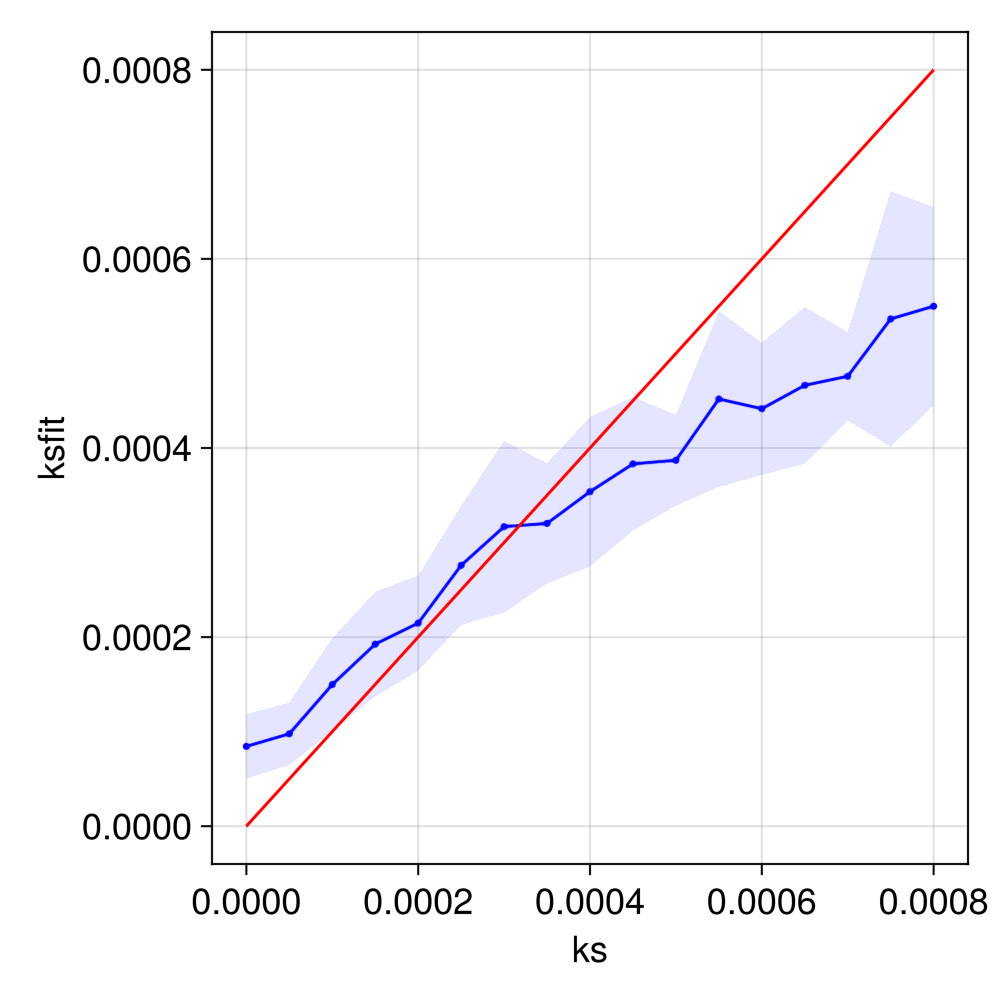

In [20]:
totMeanVec = []
totStdVec = []
for (i, ks) in enumerate(varVec2)
    push!(totMeanVec, mean(meanVec[i]))
    push!(totStdVec, sqrt.(sum(stdVec[i].^2)) ./ length(stdVec[i]))
end
totMeanVec = FVF(totMeanVec)
totStdVec = FVF(totStdVec)

f = Figure(resolution = (500, 500), fontsize = 18, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    xlabel = "ks",
    ylabel = "ksfit"
    )

Makie.lines!(varVec2, totMeanVec, color = :blue)
Makie.scatter!(varVec2, totMeanVec, color = :blue, markersize = 5)
# Makie.errorbars!(varVec2, totMeanVec, totStdVec)

# Fill between the mean ± standard deviation
Makie.band!(varVec2, totMeanVec .- totStdVec, totMeanVec .+ totStdVec, color = :blue, alpha = 0.1)

Makie.lines!(varVec2, varVec2, color = :red)
#Makie.scatter!(varVec2, varVec2, color = :red)

current_figure()

In [98]:
pathBase = "/Users/csfloyd/Dropbox/Projects/RLNematic/Dirs/AnalyzedData/"
pathName = pathBase * "rewards_seed_ks_rel_4_2.jld2"
pathName = pathBase * "rewards_sepPlus_seed_ks_rot_full.jld2"
d = load(pathName)

varVec1 = FVF(sort(collect(keys(d["retDict"]))))
varVec2 = FVF(sort(collect(keys(d["retDict"][varVec1[4]]))));

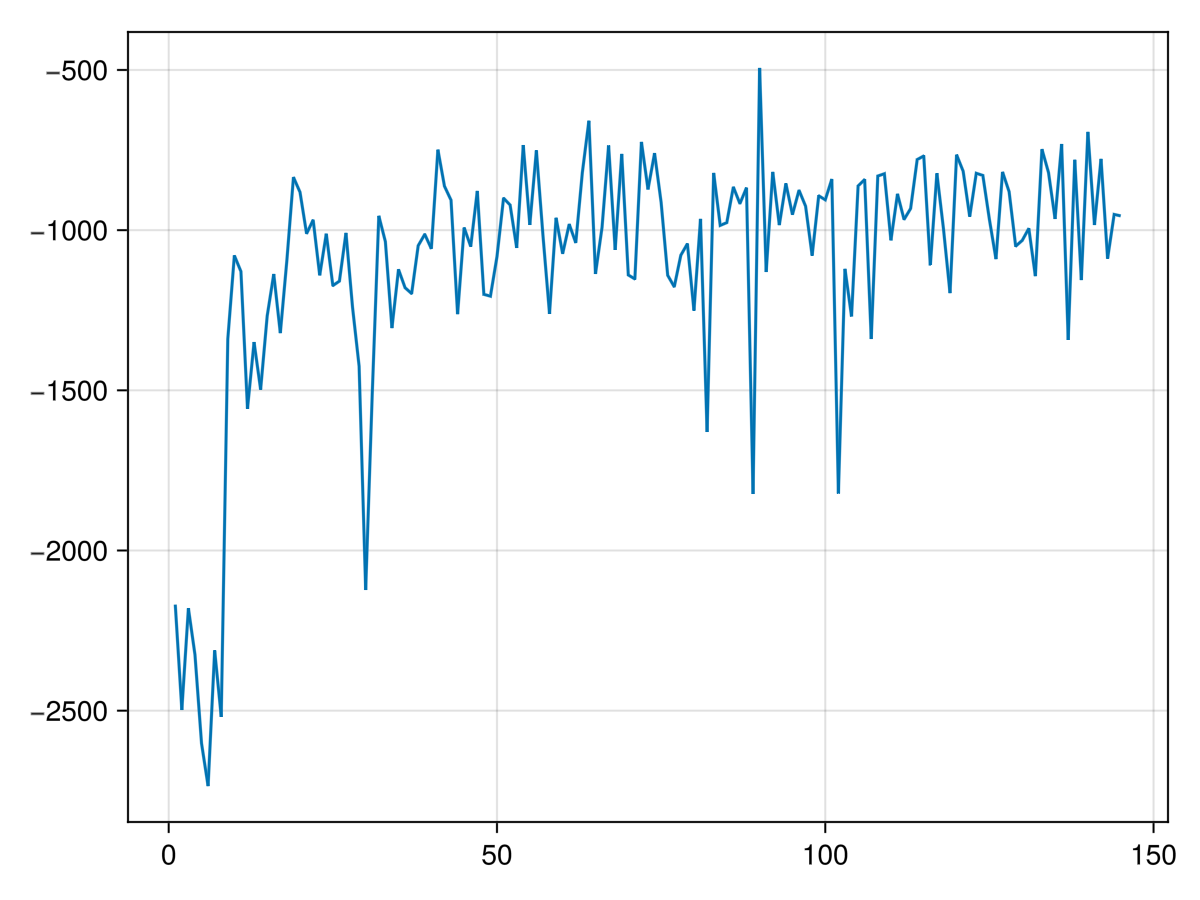

In [27]:
Makie.lines([sum(d["retDict"][1][0.0][ep]) for ep in 1:145] )

In [117]:
meanVec = []
stdVec = []

ep1 = 80
ep2 = 140

for seed in varVec1
    means = []
    stds = []
    for ks in varVec2
        try
            rews = [sum(d["retDict"][seed][ks][ep]) for ep in 1:length(d["retDict"][seed][ks])] 
            push!(means, mean(rews[ep1:ep2]))
            push!(stds, std(rews[ep1:ep2]))
        catch
        end
    end
    push!(meanVec, means)
    push!(stdVec, stds)
end

In [120]:
[mean(m) for m in meanVec]

10-element Vector{Float64}:
 -408.36149951784
 -397.14421106557376
 -398.97275795564127
 -400.2384733606557
 -401.9384040501447
 -404.797974927676
 -401.3481195756991
 -405.26964802314365
 -396.4138138862103
 -403.09076663452265

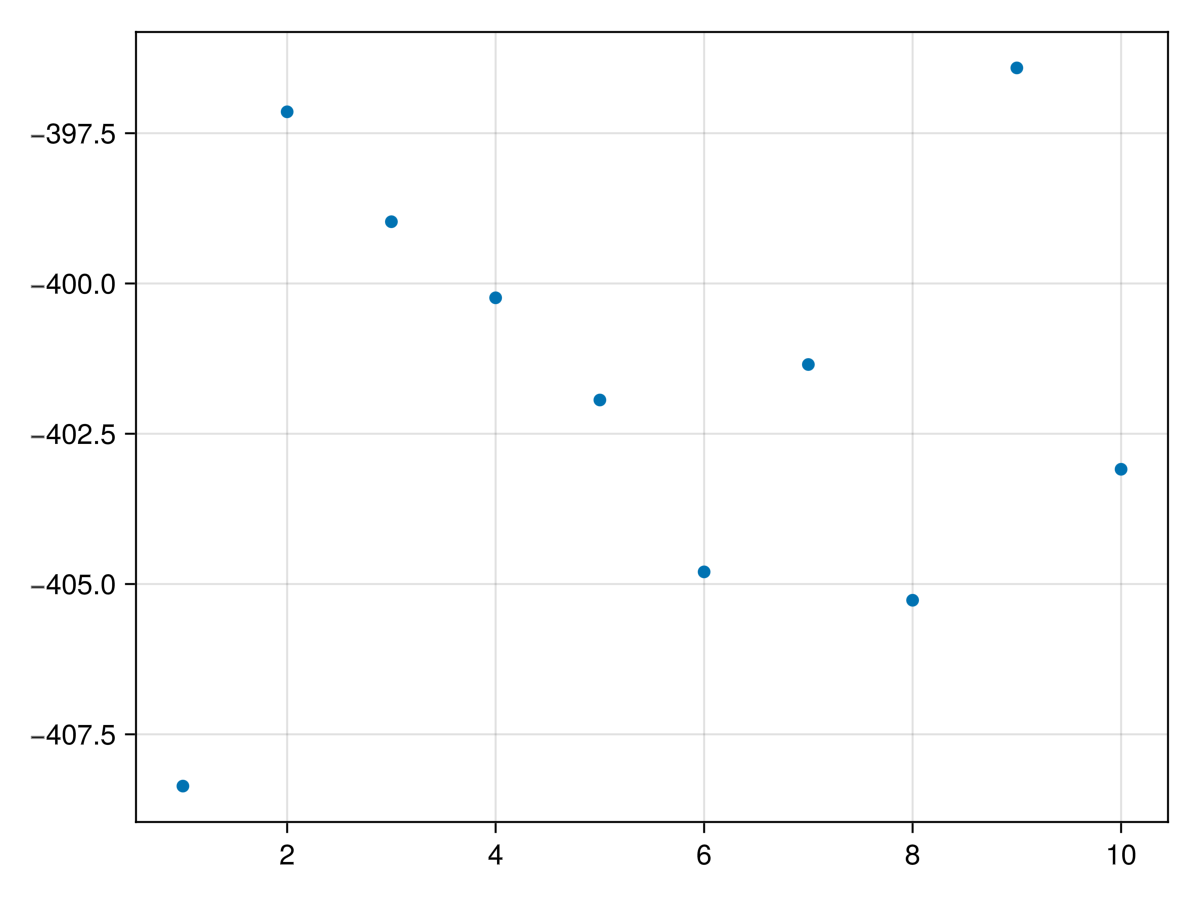

In [123]:
Makie.scatter(FVF([mean(m) for m in meanVec]))

In [471]:
pathBase = "/Users/csfloyd/Dropbox/Projects/RLNematic/Dirs/AnalyzedData/"
pathName = pathBase * "separations_sepPlus_seed_l0.jld2"

function reverse_nesting(nested_dict)
    # Get the subkeys from one of the main keys (assuming all main keys have the same subkeys)
    subkeys = keys(nested_dict[collect(keys(nested_dict))[1]])
    # Create a new dictionary where subkeys will be the first-level keys
    reversed_dict = Dict(subkey => Dict() for subkey in subkeys)
    # Iterate over the original nested dictionary and reorganize
    for (key, subdict) in nested_dict
        for (subkey, value) in subdict
            reversed_dict[subkey][key] = value
        end
    end
    return reversed_dict
end

#@suppress_err d = load(pathName * "SavedData.jld2")
d = load(pathName)
#keys(first(d["retDict"]))
d["retDict"] = reverse_nesting(d["retDict"])

varVec1 = FVF(sort(collect(keys(d["retDict"]))))
varVec2 = FVF(sort(collect(keys(d["retDict"][varVec1[3]]))));

println("Done")
length(varVec2)

Done


5

ModSep (generic function with 1 method)

60.0


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/iRM0c/src/scenes.jl:220


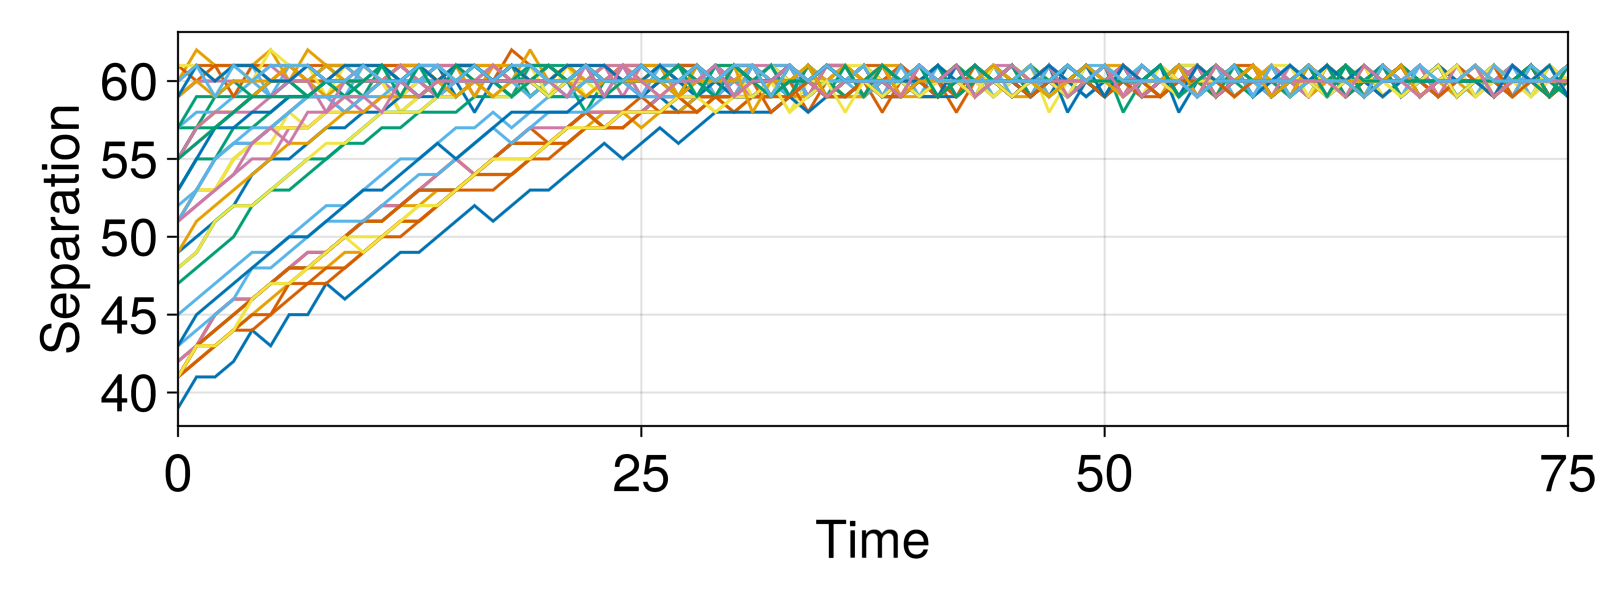

In [495]:
## horizontal separation

using LsqFit
using Statistics

f = Figure(resolution = (800, 300), fontsize = 26, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    xlabel = "Time",
    ylabel = "Separation"
    )

ksInd = 5;
sepList = d["retDict"][varVec1[3]][varVec2[ksInd]]
#sepList = d["retDict"][varVec1[5]]
println(varVec2[ksInd])

ep1 = 1
ep2 = 30

ep1 = 100 - 0
ep2 = 145 - 0

expList = []
colorSet = Makie.wong_colors()
upFit = 50;

for (i, ep) in enumerate(collect(ep1:ep2))
    colorIndex = i % length(colorSet)
    lineColor = colorSet[colorIndex + 1]
    #sepListOrig = FVF(abs.(sepList[ep]))
    sepListOrig = FVF(ModSep(sepList[ep],100))
    #sepListOrig = FVF(abs.(sepList[ep]))
    if length(sepListOrig) > 3
        xVals = collect(0:length(sepListOrig)-1)
        s0 = sepListOrig[1]
        
        #if (abs(s0-varVec2[ksInd]) > 2) #&& (abs(s0-50) < 10)
            Makie.lines!(xVals, sepListOrig, color= lineColor)
            yVals = FVF(sepListOrig)
            linFun(t, p) = -(50.0 .- s0) .* exp.(-(t) .* p[1]) .+ 50.0
            fitExp = curve_fit(linFun, xVals[1:upFit], yVals[1:upFit], [1e-2])
            #fitExp = curve_fit(linFun, xVals, yVals, [1e-2])
#             Makie.lines!(xVals, FVF(linFun(xVals, fitExp.param)), 
#                 linewidth = 1, color = (lineColor, 0.8), linestyle = :dash)
#             push!(expList, fitExp.param[1] / 50)
        #end
    end


end
Makie.xlims!(0,75)
#Makie.ylims!(40, 60)

# expList = sort(expList)[2:end-2]
# println(mean(expList))
# println(std(expList))
# #println(maximum(expList))
Makie.current_figure()

In [243]:
ps = collect(-0.3:0.001:0.3)

behaviorArray = zeros(length(varVec2), length(varVec1), length(ps))
for (i, ks) in enumerate(varVec2)
    behaviors = []
    for (j,seed) in enumerate(varVec1)
        pol = d["retDict"][seed][ks]
        behaviorActions = []
        for p in ps
            behaviorAction = pol([p])[1]
            push!(behaviorActions, behaviorAction)
        end
        behaviorArray[i,j,:] .= behaviorActions      
    end
    #push!(behaviorList, behaviors)
end

#mean(behaviorList[2], dims = 1)

In [198]:
meanBehavior = mean(behaviorArray, dims = 2);
stdBehavior = std(behaviorArray, dims = 2);

In [232]:
#std(behaviorArray[2,:,1])
minimum(behaviorArray[2,:,1])

-0.5051015465422943

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/iRM0c/src/scenes.jl:220


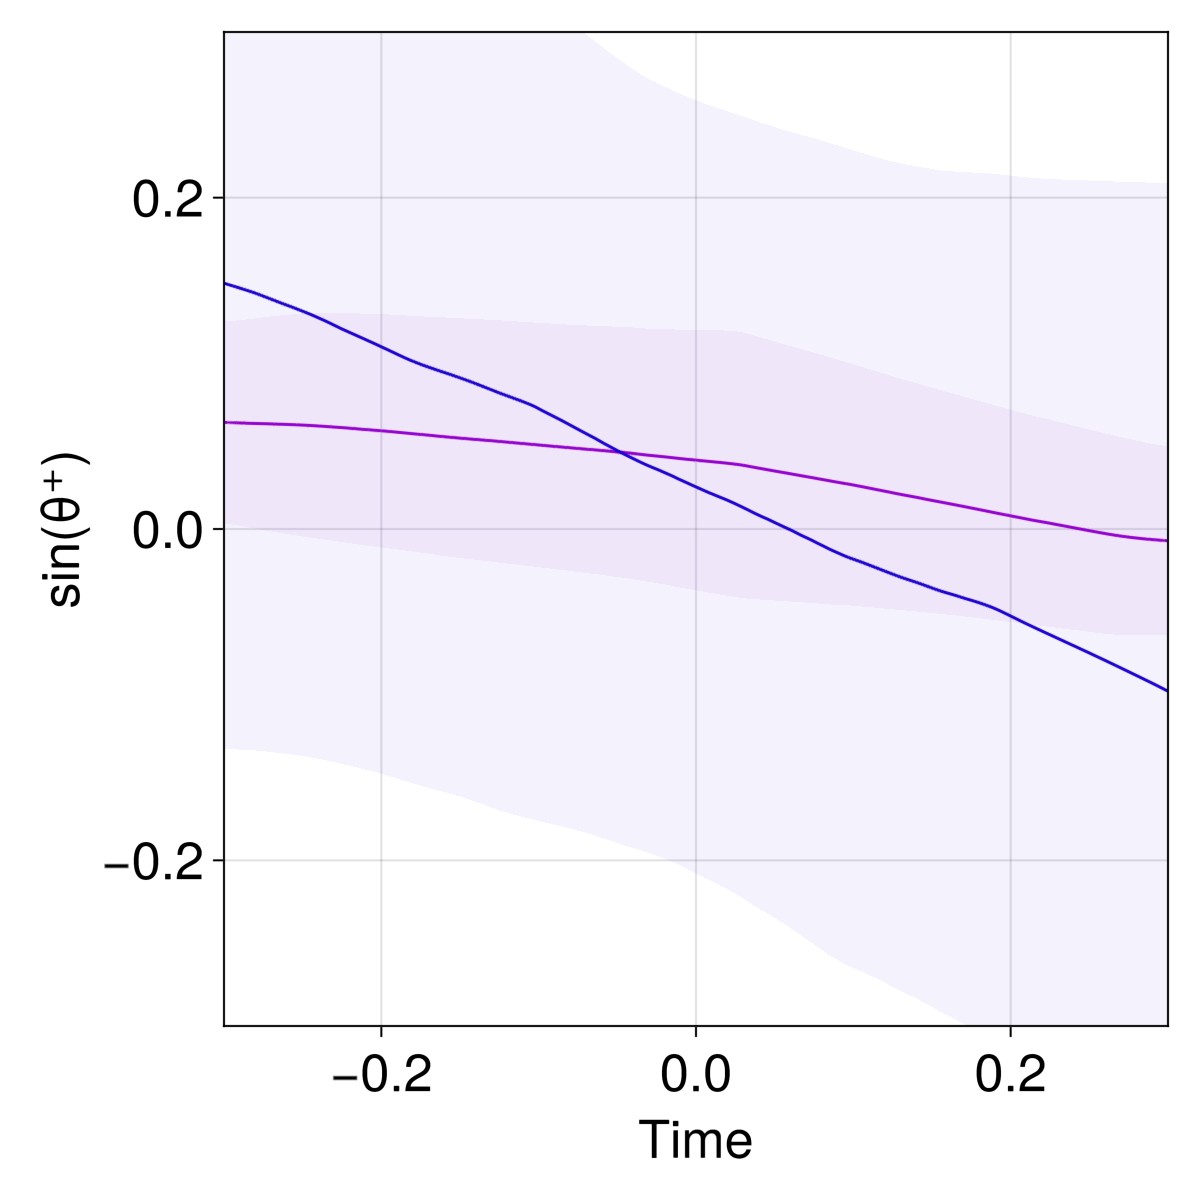

In [241]:
f = Figure(resolution = (600, 600), fontsize = 26, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    xlabel = "Time",
    ylabel = "sin(θ⁺)"
    )

numV = length(varVec2)
colors = range(colorant"magenta3", stop=colorant"blue3", length=numV)

ps = collect(-0.3:0.001:0.3)
for i in [5,15]
    mean_vals = meanBehavior[i,1,:]
    std_vals = stdBehavior[i,1,:]
    
    # Plot the lines for mean behavior
    Makie.lines!(ps, mean_vals, color = colors[i])
    
    # Fill between the mean ± standard deviation
    Makie.band!(ps, mean_vals .- std_vals, mean_vals .+ std_vals, color = colors[i], alpha = 0.05)
end
Makie.xlims!(-0.3, 0.3)
Makie.ylims!(-0.3, 0.3)

current_figure()

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/iRM0c/src/scenes.jl:220


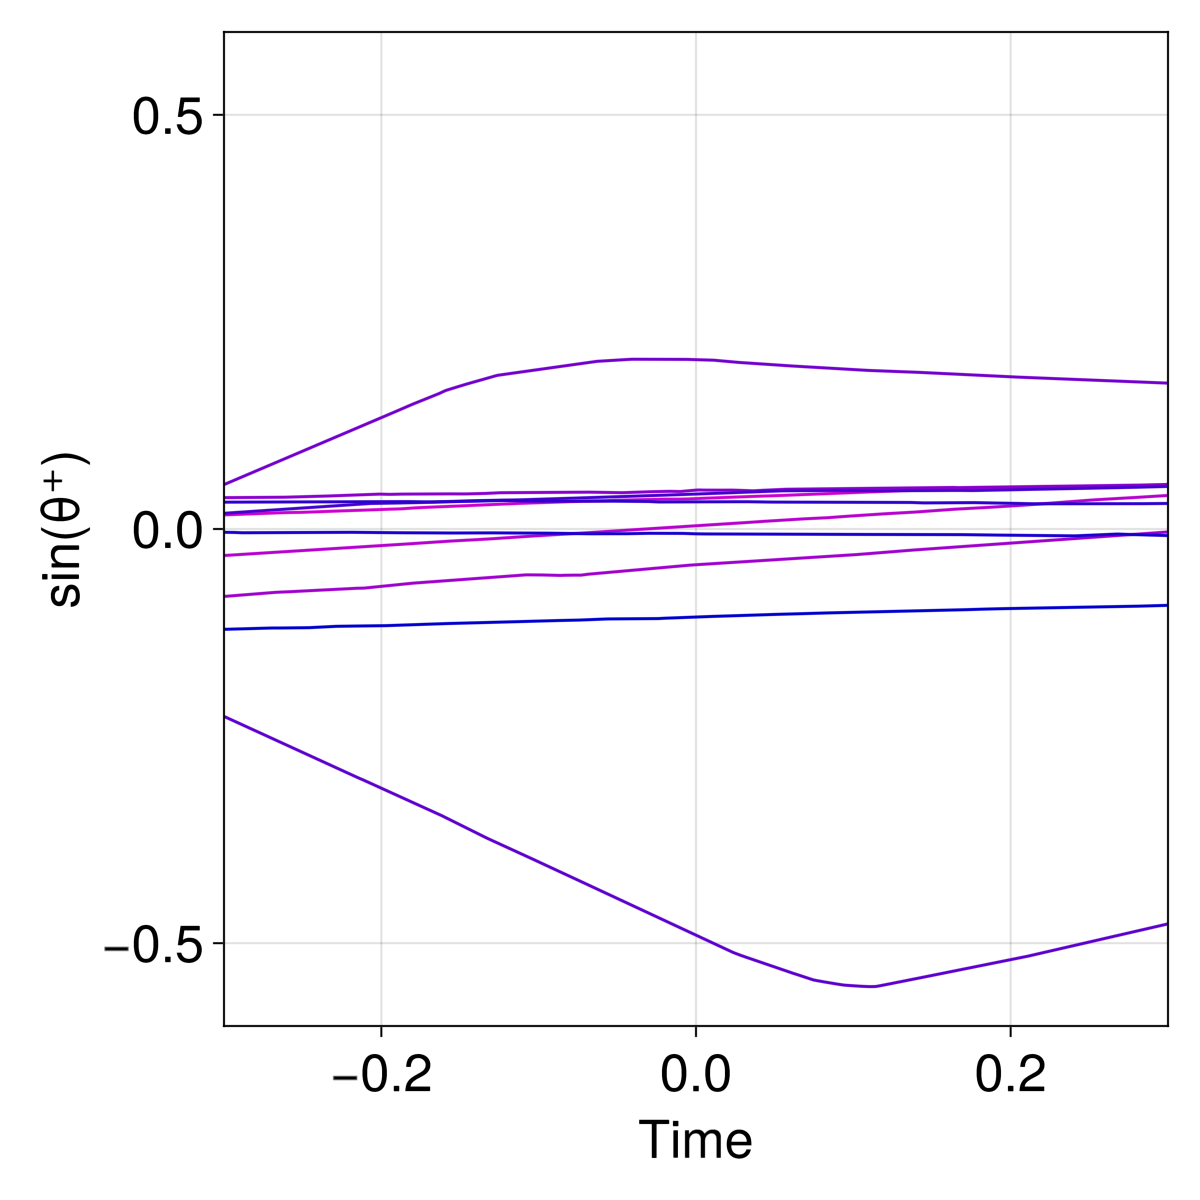

In [251]:
f = Figure(resolution = (600, 600), fontsize = 26, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    xlabel = "Time",
    ylabel = "sin(θ⁺)"
    )

numV = length(varVec1)
colors = range(colorant"magenta3", stop=colorant"blue3", length=numV)

ps = collect(-0.3:0.001:0.3)
for i in 1:length(varVec1)    
    # Plot the lines for mean behavior
    Makie.lines!(ps, behaviorArray[3,i,:], color = colors[i])
    
end
Makie.xlims!(-0.3, 0.3)
Makie.ylims!(-0.6, 0.6)

current_figure()